In [1]:
import os
import sqlite3
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
import seaborn as sns
from tqdm import tqdm_notebook
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Liste des fichiers exploitables

In [58]:
bss_era5 = pd.Series([_.replace(".pkl","") for _ in os.listdir(r"./data/era5") if _.endswith(r".pkl")], name="era5")
bss_piezo = pd.Series([_.replace(".csv","") for _ in os.listdir(r"./data/piezo") if _.endswith(r".csv")], name="piezo")
piezos_communs = np.intersect1d(bss_era5, bss_piezo)

requete_fichier_combined = f"""
        UPDATE data_piezo
        SET fichier_combined =
        (CASE WHEN code_bss IN {tuple(piezos_communs)}
        THEN 1 ELSE 0 END)
        """
requete_sql(requete_fichier_combined)
print("Base de données à jour")

Connexion réussie à SQLite
Connexion SQLite est fermée
Base de données à jour


In [62]:
print(f"Il y a {len(piezos_communs)} fichiers de disponible.")
print(piezos_communs)

Il y a 96 fichiers de disponible.
['00484X0018_S1' '00493X0061_S1' '00496X0019_S1' '00497X0018_S1'
 '00501X0017_S1' '00506X0005_S1' '00516X0059_S1' '00651X0092_F'
 '00654X0014_S1' '00663X0124_F_2008' '00665X0016_S1' '00671X0052_S1'
 '00675X0019_S1' '00842X0003_S1' '00843X0024_S1' '00845X0036_S1'
 '00847X0043_S1' '00855X0001_S1' '01064X0054_P' '01066X0133_S1'
 '01074X0006_S1' '01293X0048_S1' '01293X0071_S1' '01306X0023_S1'
 '01308X0082_S1' '01561X0044_S1' '01567X0083_S1' '01568X0101_S1'
 '02936X2005_PFAEP' '03276X0009_P' '03281X0019_P' '03282X0043_S1'
 '03287X0018_S1' '03296X1032_PC1' '03627X0052_P1' '03634X0093_F'
 '03646X0086_F1' '03646X0087_F2' '03646X0105_F3' '03983X0267_PZ3'
 '03997X0004_F' '04003X0018_FAEP2' '04004X0007_F' '04323X0005_F'
 '04326X0034_F' '05736X0002_P1' '05986X0103_P16-20' '05986X0104_P16-14'
 '05986X0105_P16-02' '05986X0106_P16-21' '05991X0043_PZ32'
 '05992X1084_AUBIN' '06212X0085_P4' '06216X0226_P30-01'
 '06216X0227_P30-04' '06216X0228_P30-10' '06518X0026_P2' '06

## Jointure piezo et meteo

In [1]:
path = "./data/combined_data/"
# Le fichier doit avoir un minimum de 100 mesures
nb_min_val_com = 100

for piezo in piezos_communs :
    if not os.path.isfile(f'{path}/comb_{piezo}.csv') : #si le fichier n'existe pas 
        df_piezo = pd.read_csv(f"./data/piezo/{piezo}.csv", sep = ";", index_col=0, parse_dates=True)
        df_piezo = df_piezo.resample('1D').asfreq()
        df_era5 = pd.read_pickle(f"./data/era5/{piezo}.pkl").set_index('time').drop(["latitude", "longitude"], axis=1)
        if "expver" in df_era5.columns :
            df_era5 = df_era5.loc[df_era5["expver"]==1,:].drop("expver", axis=1)
        df = pd.merge(df_piezo, df_era5, how='inner', left_index=True, right_index=True)
        nb_com_obs = df.shape[0]
        if nb_com_obs >= nb_min_val_com :
            df.to_csv(f"data/combined_data/comb_{piezo}.csv" ,sep=";", index=True)
            print(f"Le fichier comb_{piezo}.csv a été créé et contient {nb_com_obs} obseravtions.")
        else :
            print(f"Le piezo {piezo} ne contient pas assez de données (seulement {nb_com_obs}).")
    else : 
        print(f"Le fichier comb_{piezo}.csv existe déjà.")

NameError: name 'piezos_communs' is not defined

## Liste des piezos disponibles

Lecture des infos depuis la base de données :

In [61]:
connexion = sqlite3.connect('./data/liste_piezos.db')
curseur = connexion.cursor()

requete = f"SELECT * FROM data_piezo WHERE code_bss IN {tuple(piezos_communs)}"
df_piezo = pd.read_sql_query(requete, connexion, index_col='code_bss')

curseur.close()
connexion.close()

df_piezo["date_debut"] = pd.to_datetime(df_piezo["date_debut"])
df_piezo["date_fin"] = pd.to_datetime(df_piezo["date_fin"])

print(f"Il y a {df_piezo.shape[0]} fichiers de disponible.")

Il y a 96 fichiers de disponible.


## Tableau d'informations

In [7]:
df_piezo

date_debut   date_fin  nb_mesures_piezo code_dpt  \
code_bss                                                           
00484X0018_S1   1970-01-12 2022-05-24              6280       02   
00493X0061_S1   1970-01-06 2019-12-27              5428       02   
00496X0019_S1   1970-01-12 2022-05-24              5742       02   
00497X0018_S1   1970-01-12 2022-05-24              7031       02   
00501X0017_S1   1974-02-13 2022-05-24              4522       02   
...                    ...        ...               ...      ...   
08688X0023_PZ1  2009-07-16 2022-05-22              4567       05   
09441X0013_P1   1988-02-19 2022-05-22              9058       04   
09445X0008_PZ-4 2002-05-03 2022-05-22              6928       04   
09692X0128_PZ-3 2002-03-13 2022-05-23              6761       04   
09964X0020_PZ1  2008-01-22 2022-05-23              5100       04   

                code_commune_insee              nom_commune   latitude  \
code_bss                                                                 
00484X0018_S1                02100                     Bony  49.987880   
00493X0061_S1                02061                Becquigny  50.013719   
00496X0019_S1                02319                 Fonsomme  49.900682   
00497X0018_S1                02293      Étaves-et-Bocquiaux  49.937993   
00501X0017_S1                02779               Vénérolles  49.988153   
...                            ...                      ...        ...   
08688X0023_PZ1               05008                Aspremont  44.493444   
09441X0013_P1                04110             Mallemoisson  44.036233   
09445X0008_PZ-4              04084                Estoublon  43.944923   
09692X0128_PZ-3              04230                Valensole  43.881442   
09964X0020_PZ1               04186  Saint-Laurent-du-Verdon  43.717335   

                 longitude  altitude_station  profondeur_investigation  \
code_bss                                                                 
00484X0018_S1     3.222880             135.0                     55.48   
00493X0061_S1     3.469503             144.0                     17.75   
00496X0019_S1     3.402157              98.0                     16.60   
00497X0018_S1     3.451996             150.0                     65.15   
00501X0017_S1     3.632876             147.0                     27.87   
...                    ...               ...                       ...   
08688X0023_PZ1    5.728933             718.0                     11.00   
09441X0013_P1     6.119957             493.0                      6.00   
09445X0008_PZ-4   6.167610             353.0                     18.50   
09692X0128_PZ-3   5.935546             352.2                     13.50   
09964X0020_PZ1    6.078802             432.0                     61.00   

                codes_bdlisa libelle_pe codes_masse_eau_edl  \
code_bss                                                      
00484X0018_S1        121BB01          P               AG313   
00493X0061_S1        121BD01          P               AG310   
00496X0019_S1        121BB01          P               AG313   
00497X0018_S1        121BB01          P               AG313   
00501X0017_S1        121AL01          P               HG222   
...                      ...        ...                 ...   
08688X0023_PZ1       716CA03          A               DG393   
09441X0013_P1        716CA05          M               DG355   
09445X0008_PZ-4      716CA07          E               DG356   
09692X0128_PZ-3      716CA07          V               DG356   
09964X0020_PZ1       561AC00          S               DG209   

                                   noms_masse_eau_edl  fichier_piezo  \
code_bss                                                               
00484X0018_S1    Craie de la vallée de la Somme amont              1   
00493X0061_S1                      Craie du Cambrésis              1   
00496X0019_S1    Craie de la vallée de la Somme amont              1   
00497X0018_S1    Craie de

## Evolution des mesures piezo

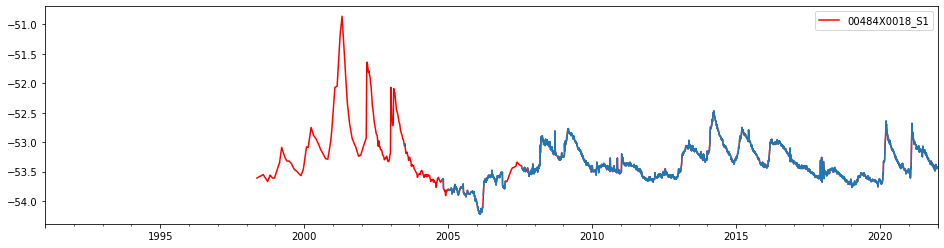

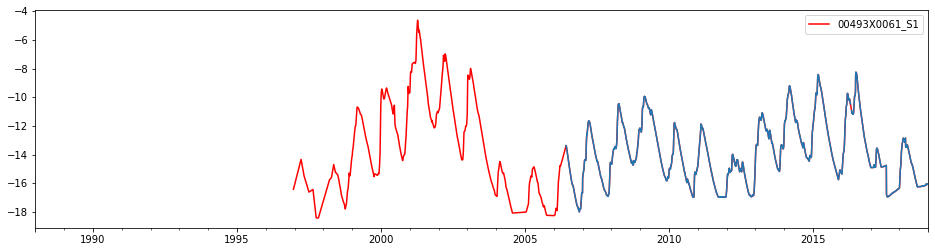

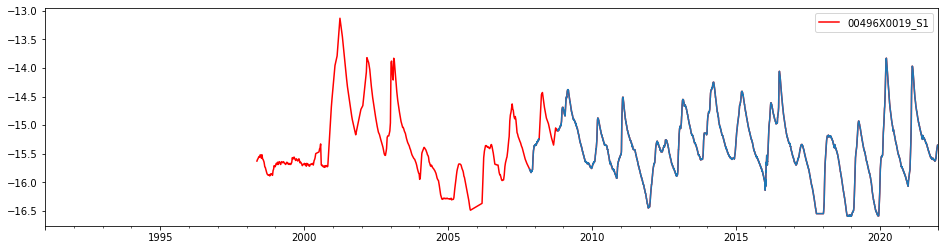

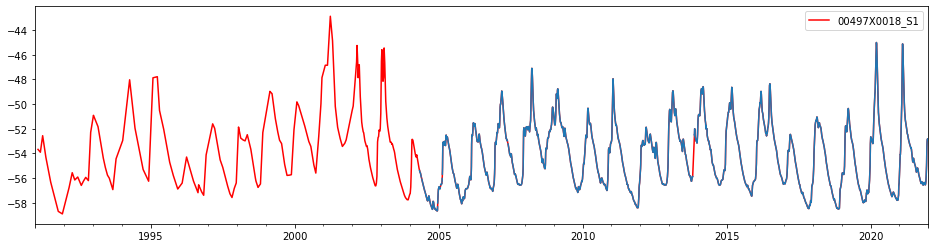

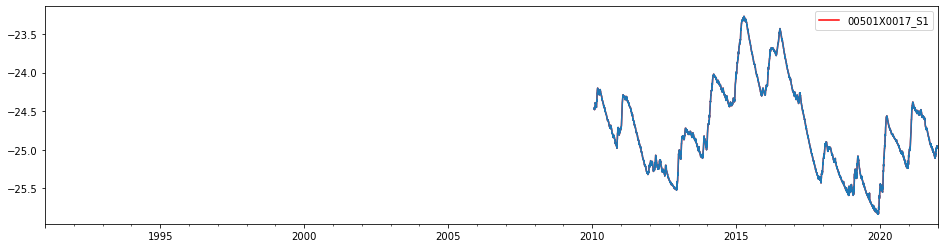

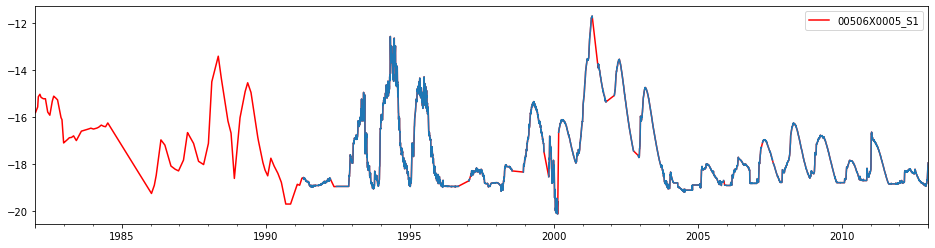

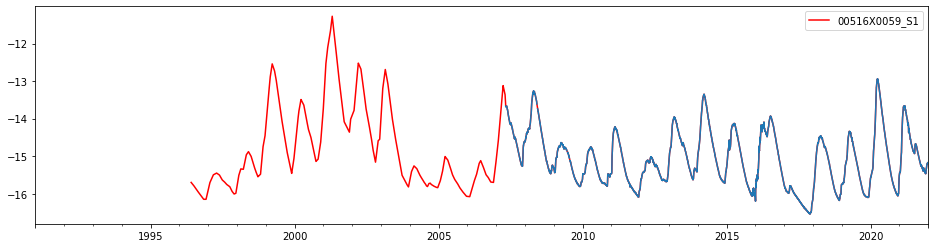

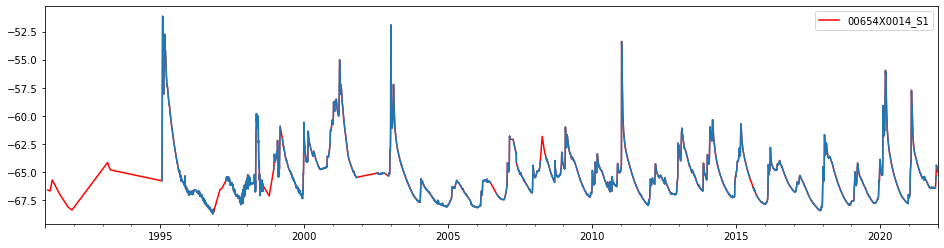

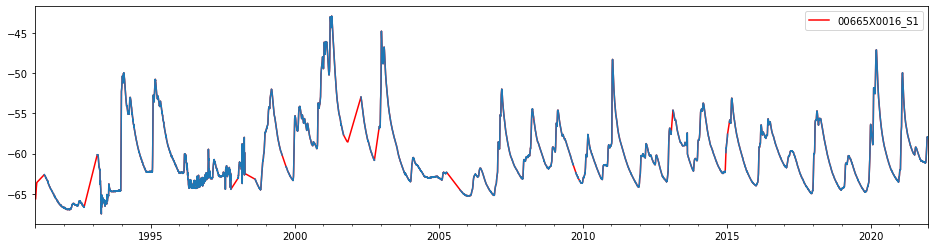

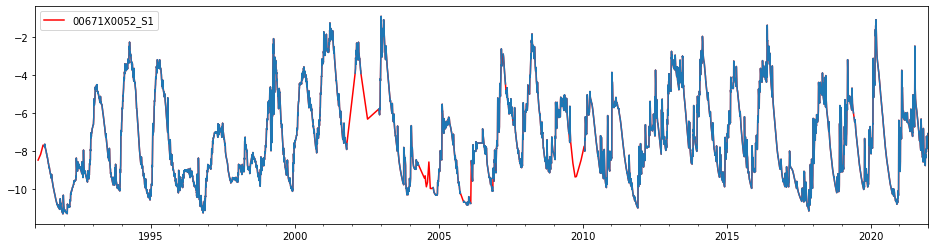

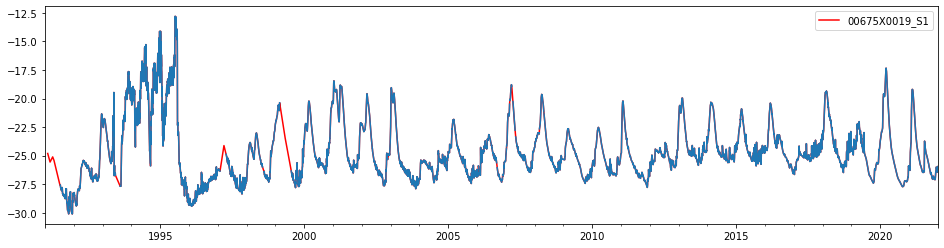

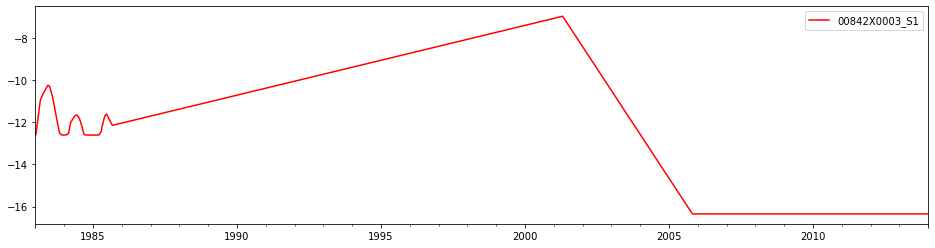

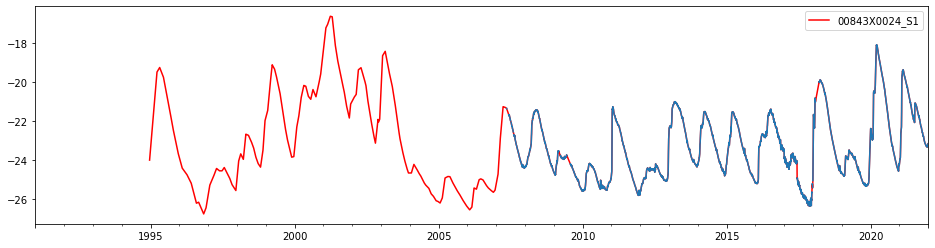

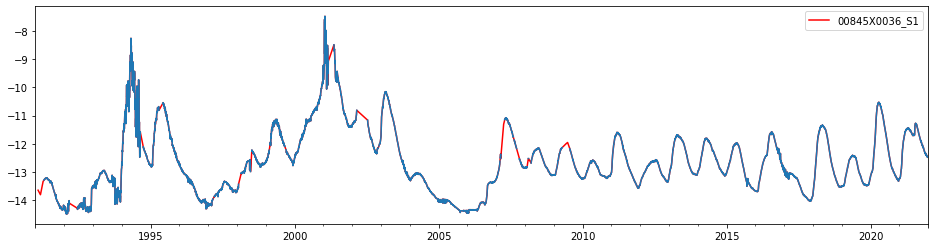

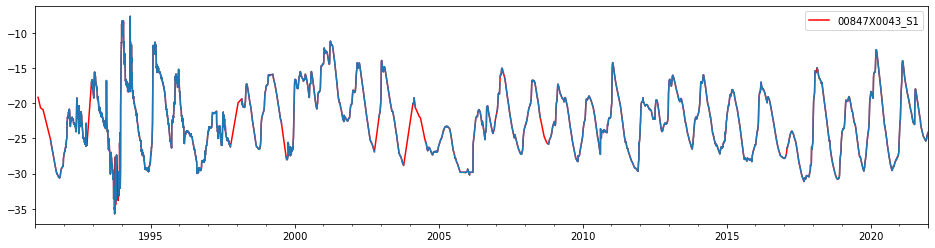

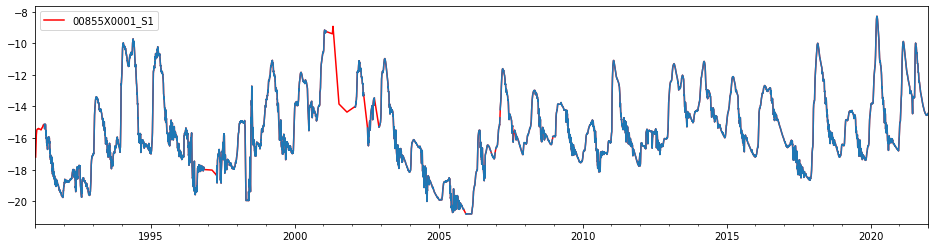

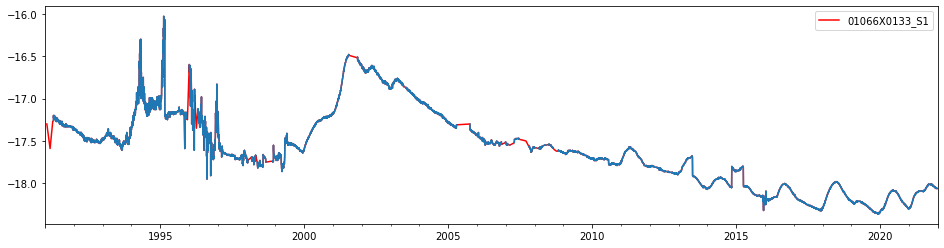

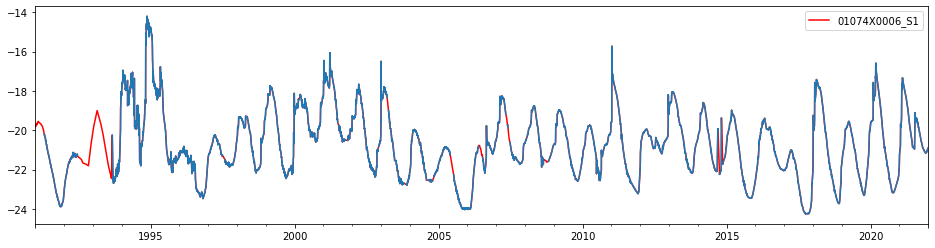

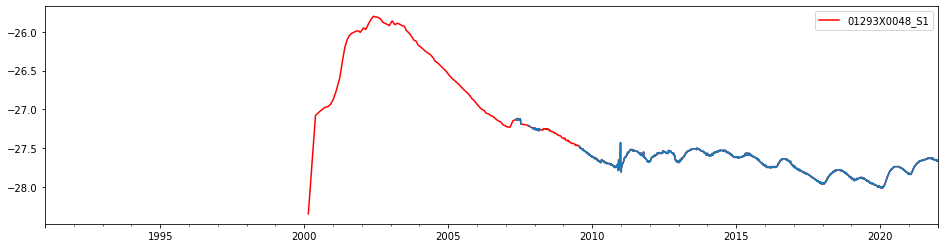

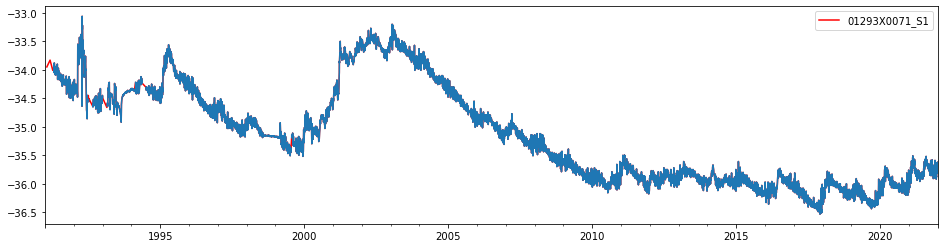

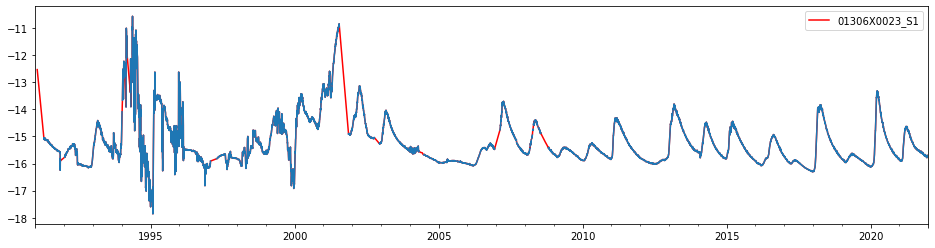

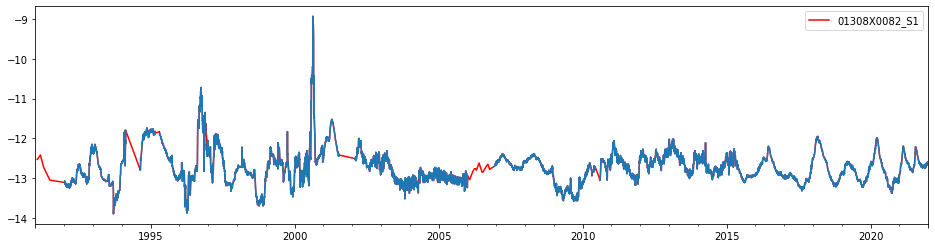

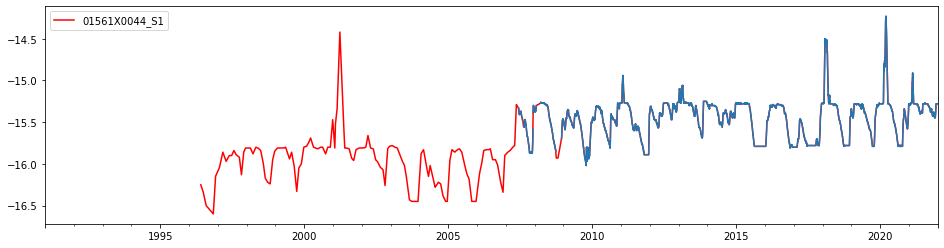

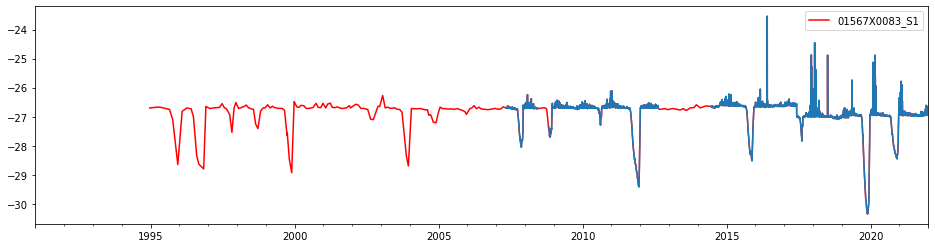

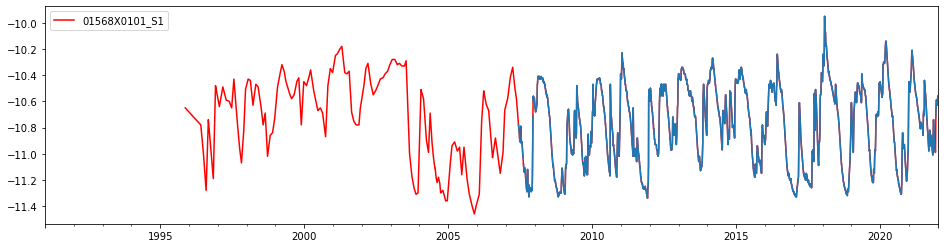

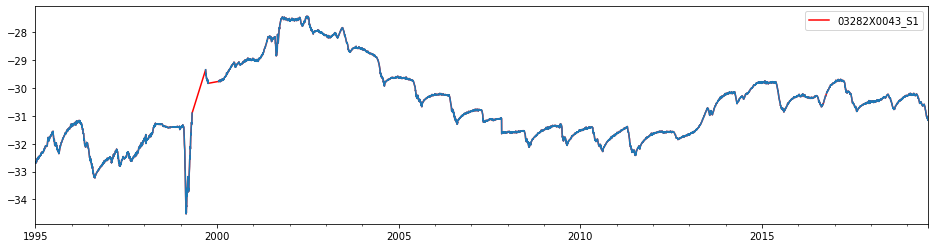

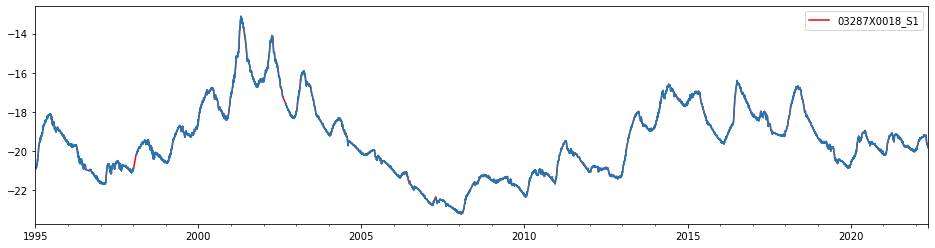

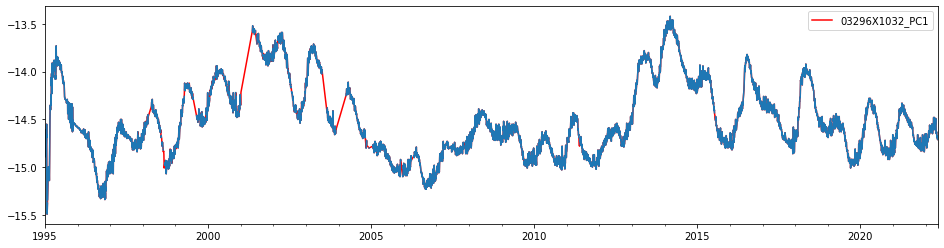

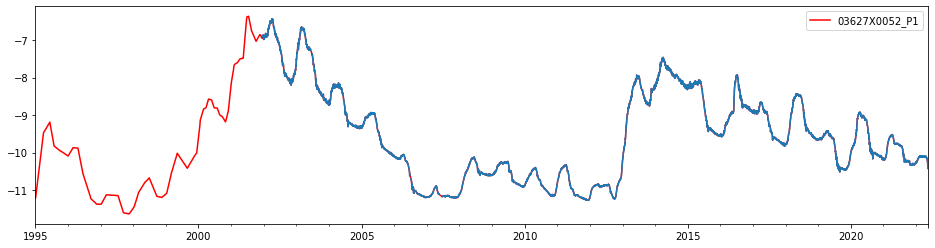

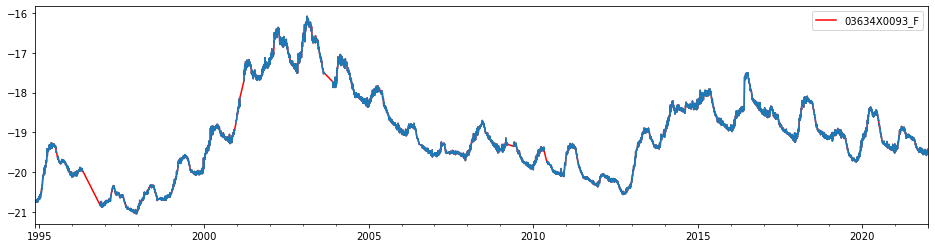

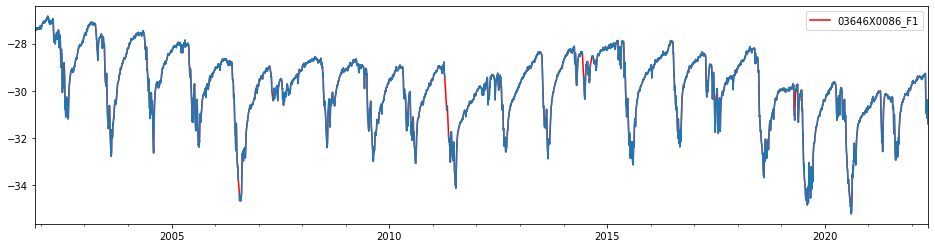

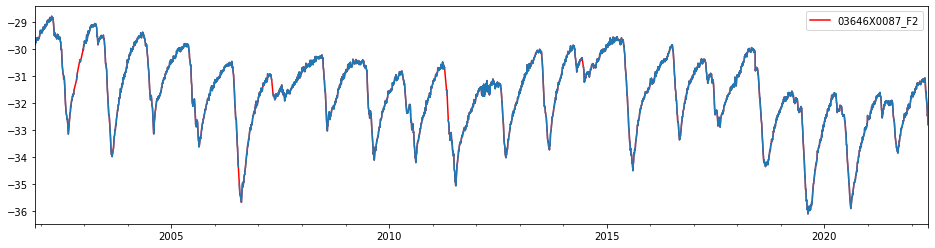

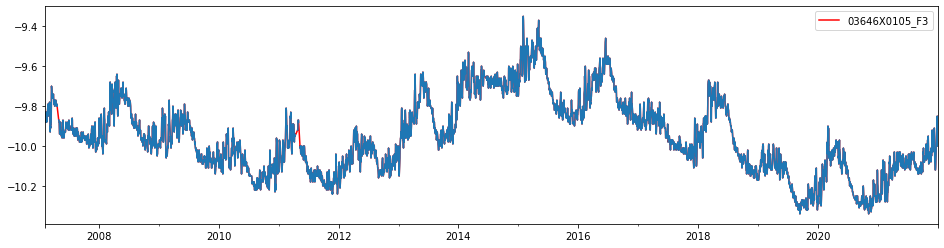

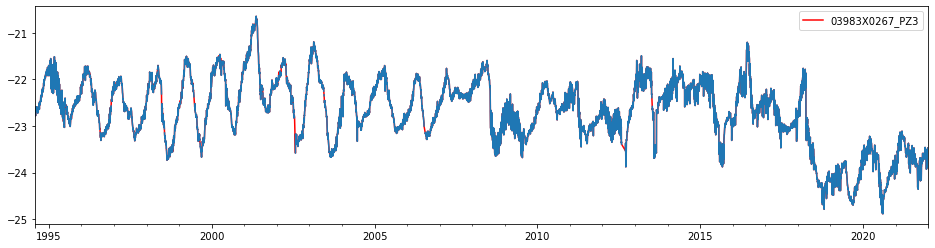

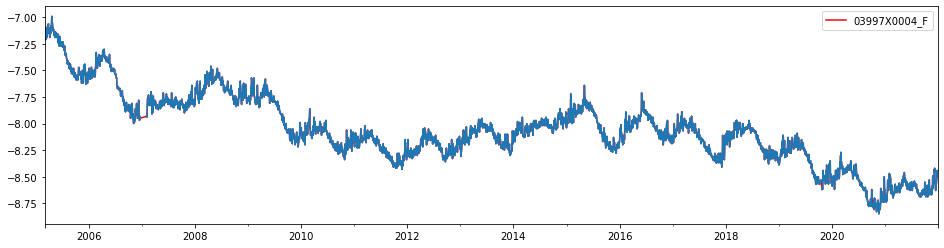

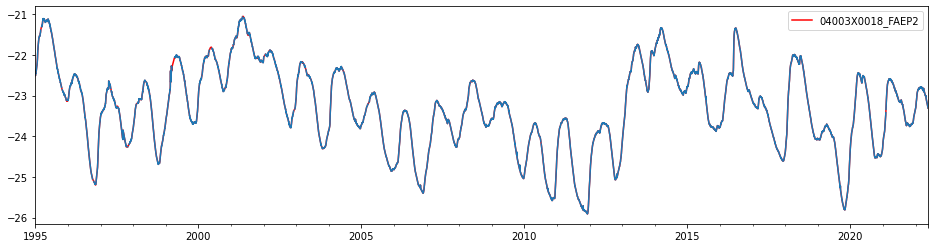

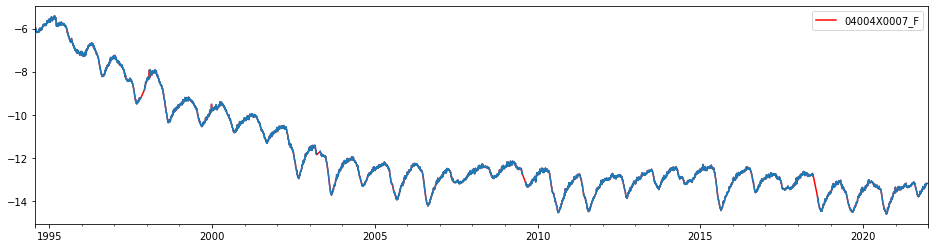

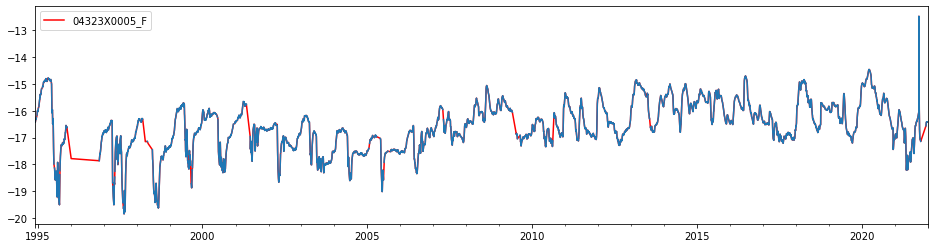

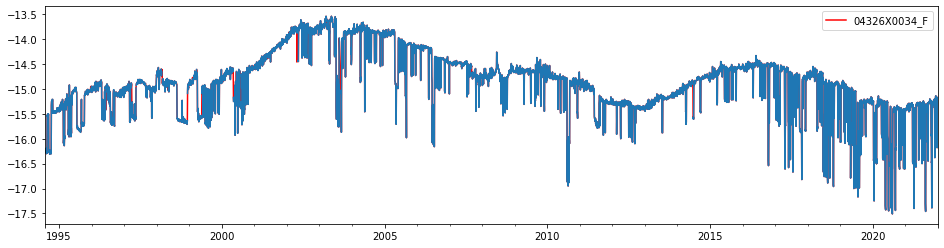

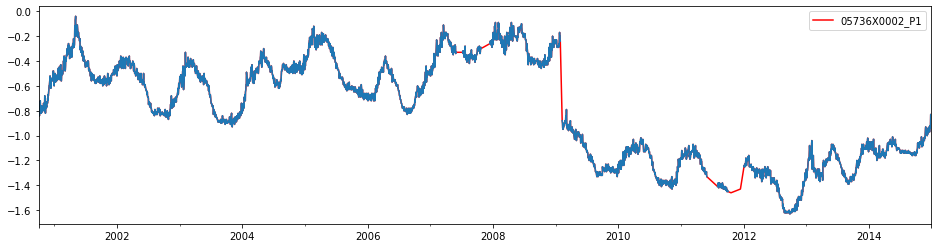

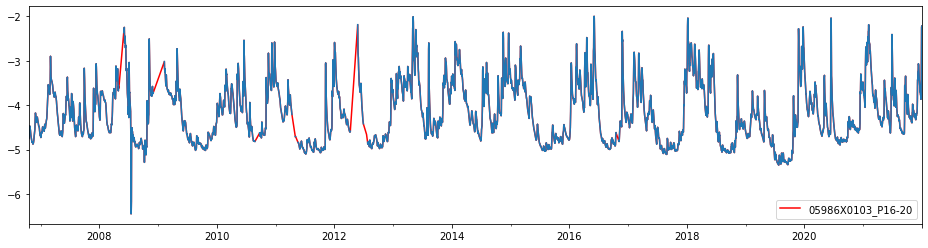

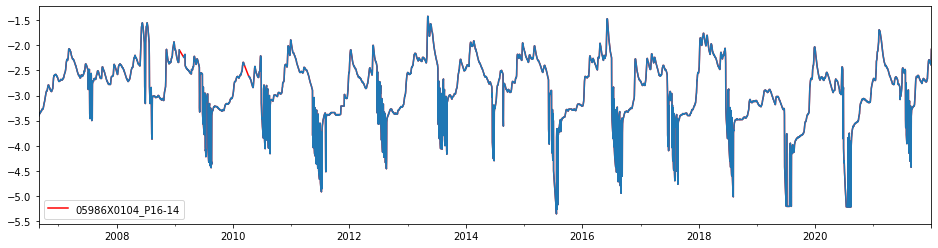

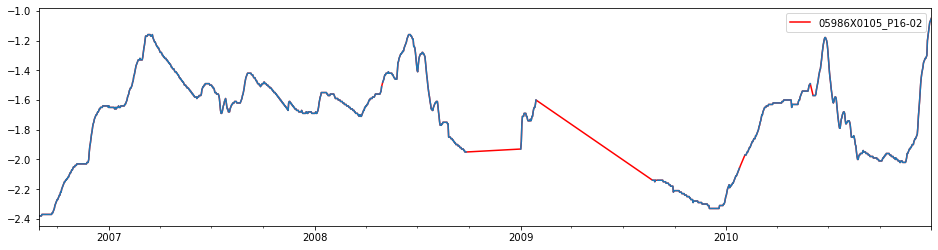

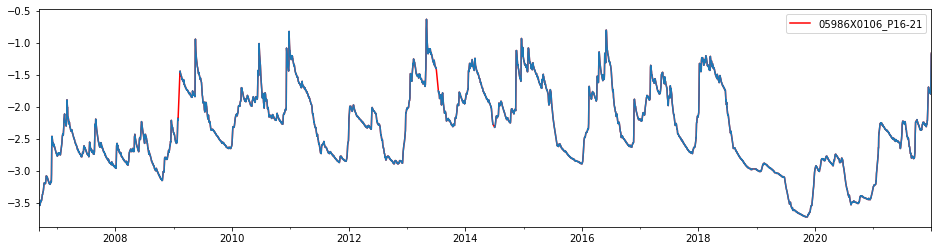

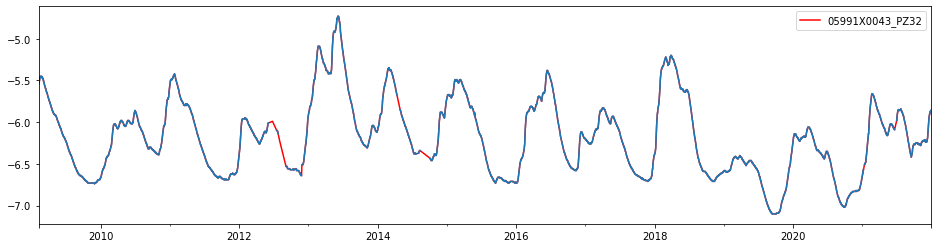

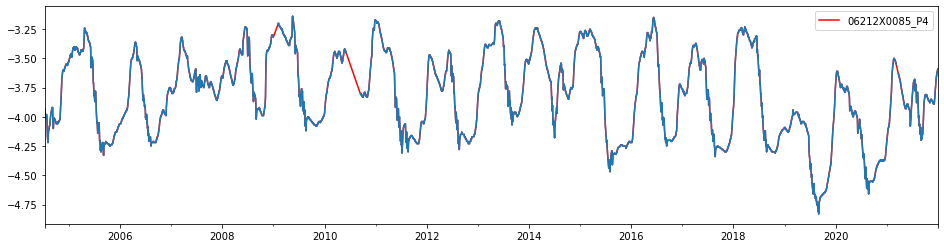

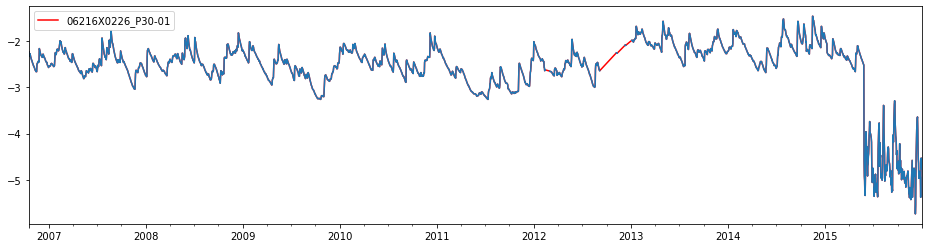

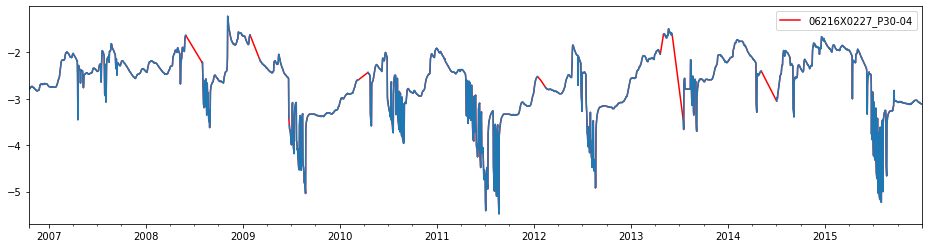

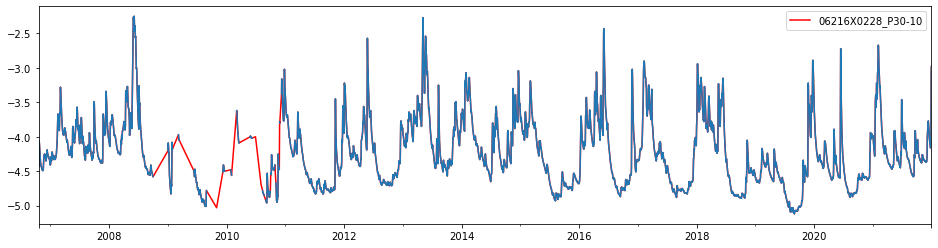

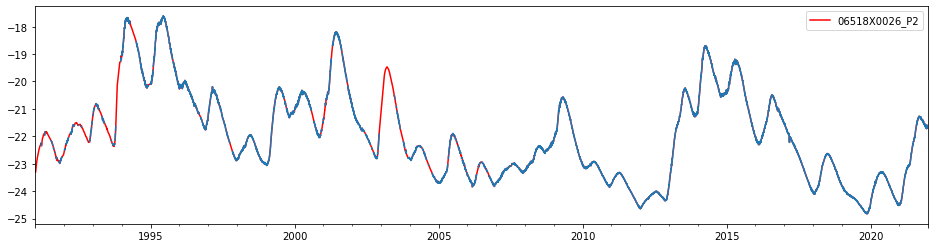

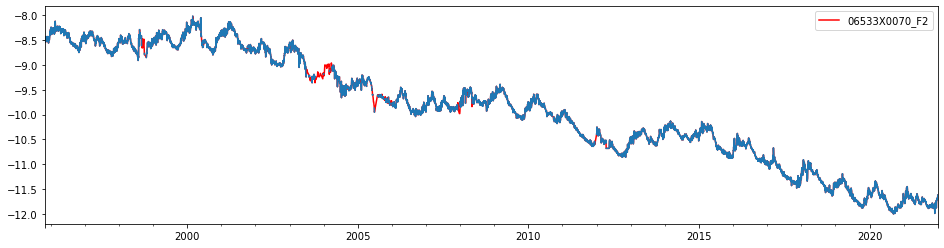

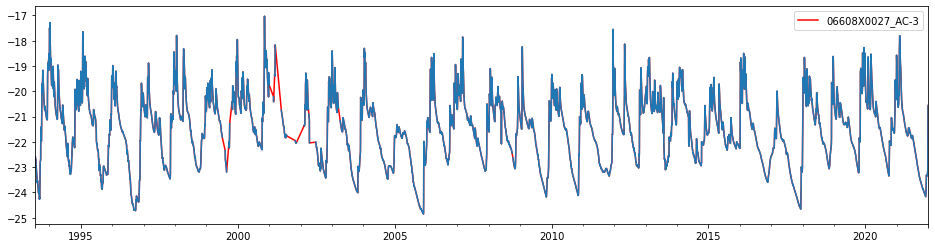

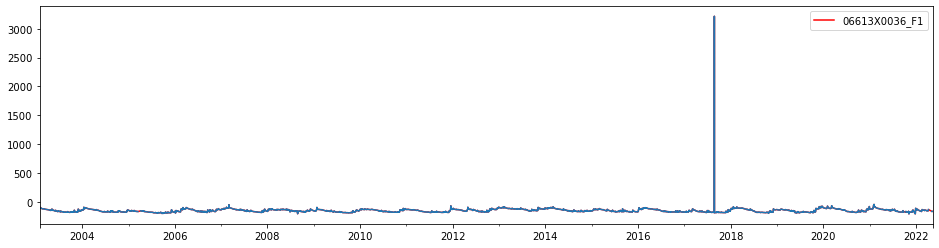

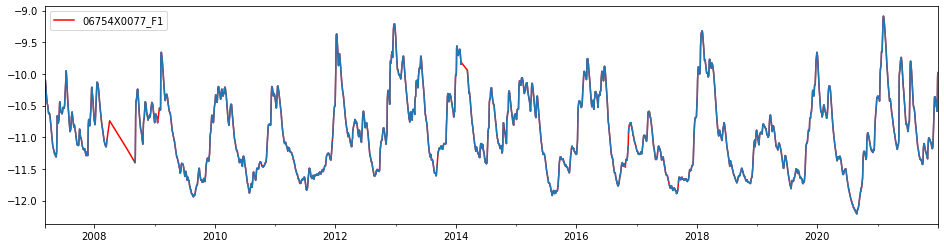

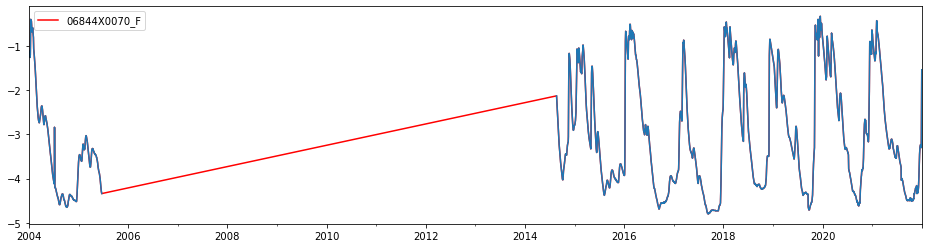

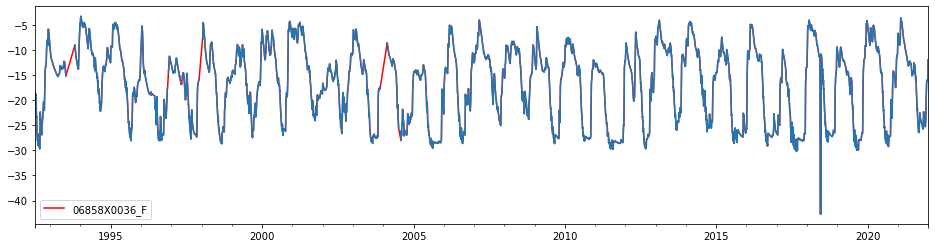

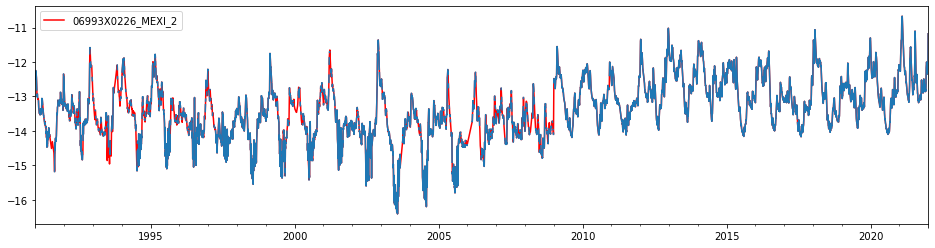

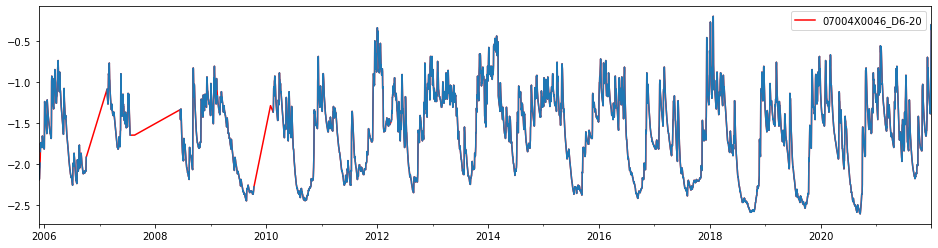

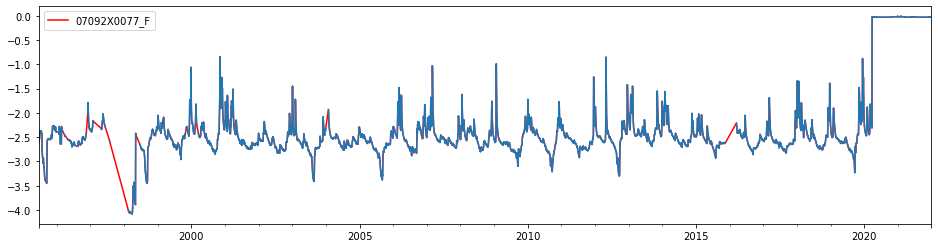

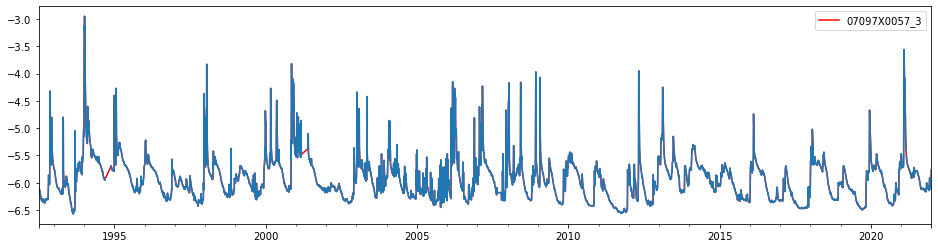

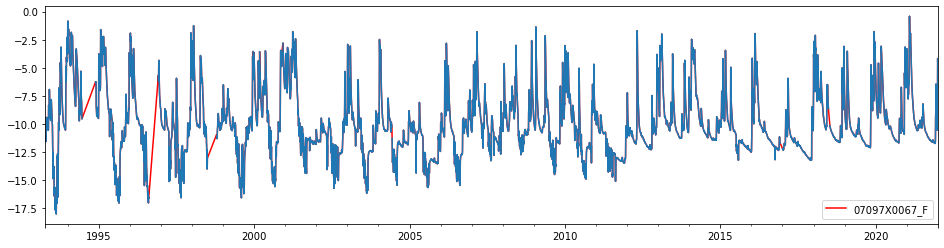

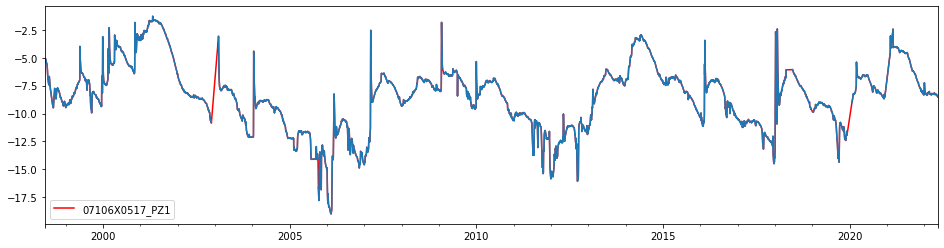

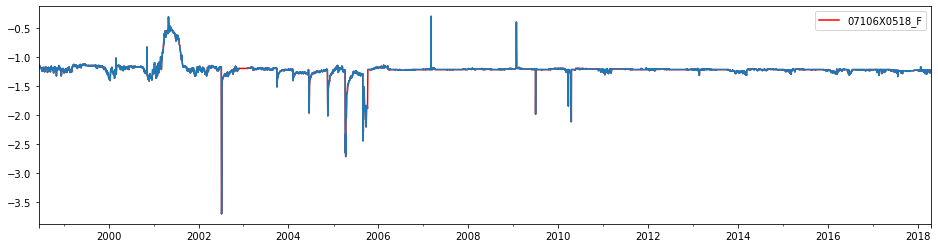

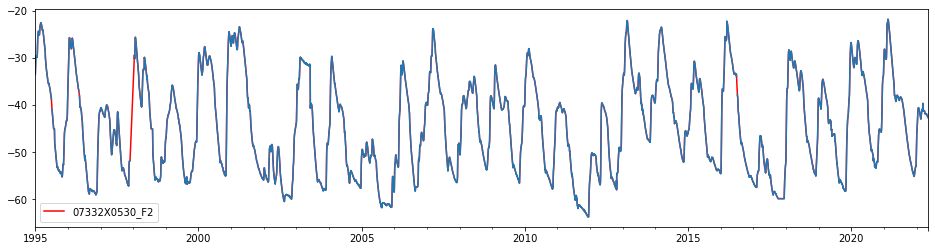

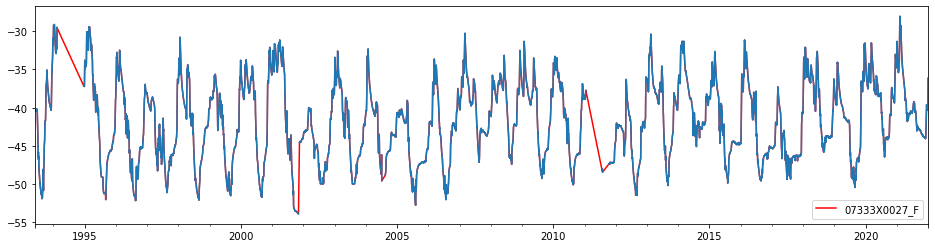

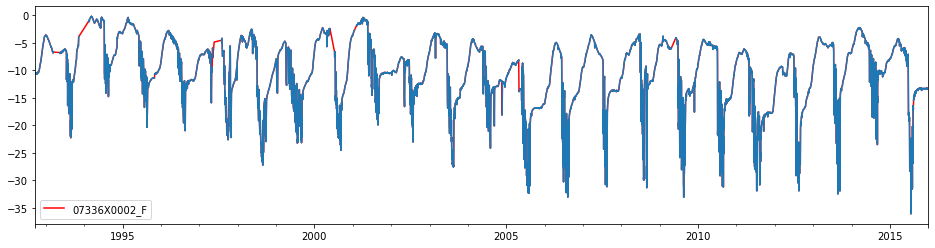

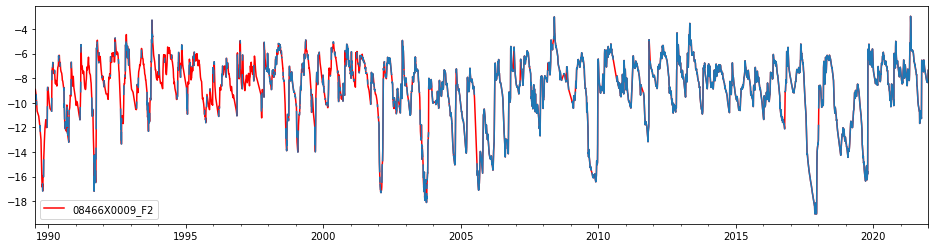

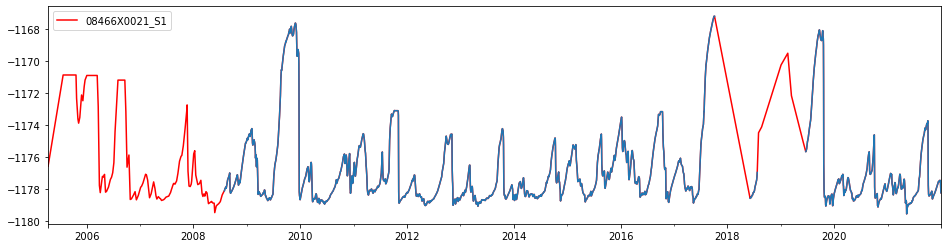

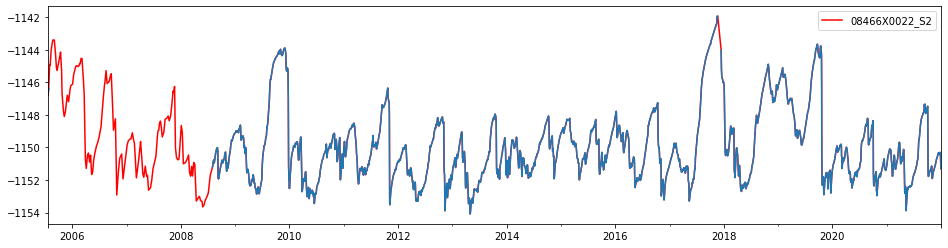

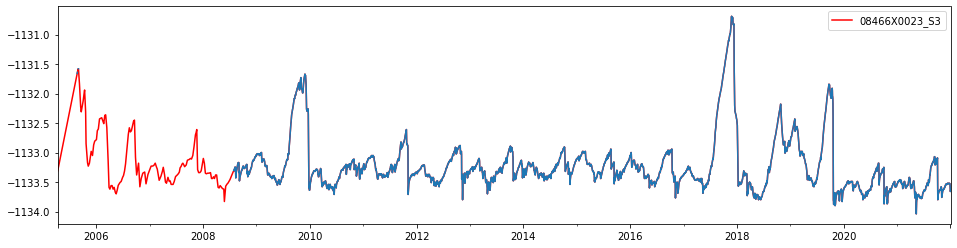

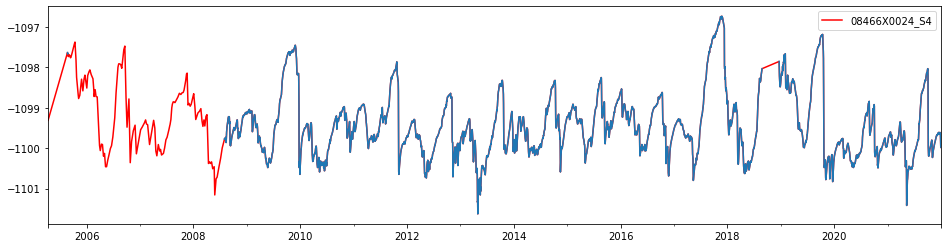

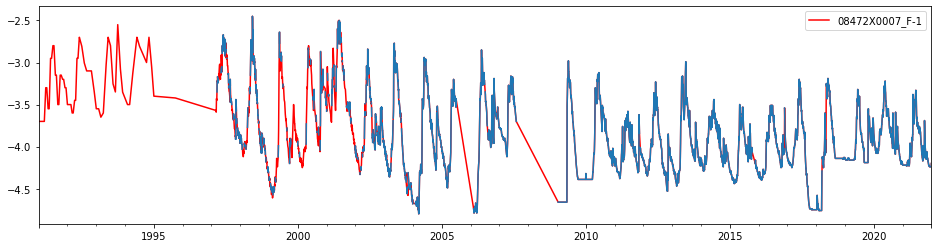

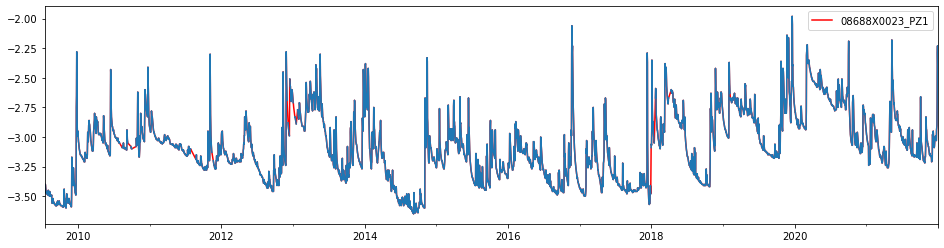

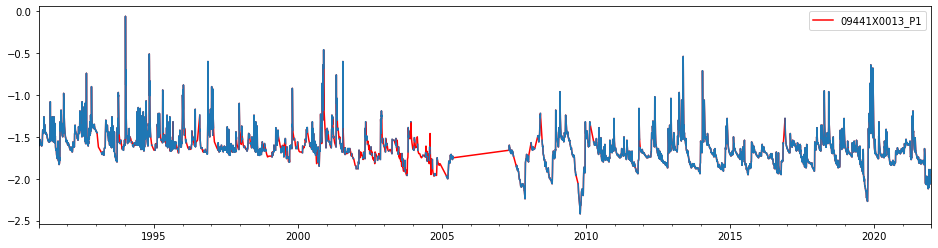

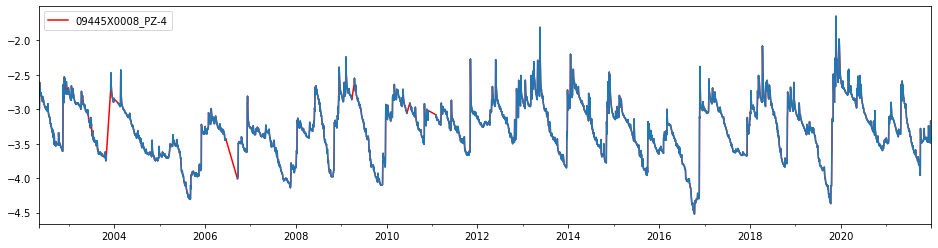

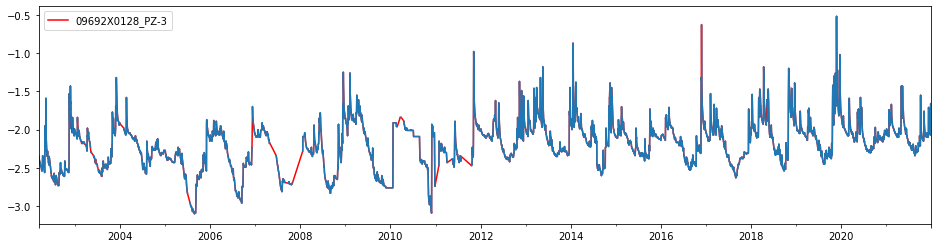

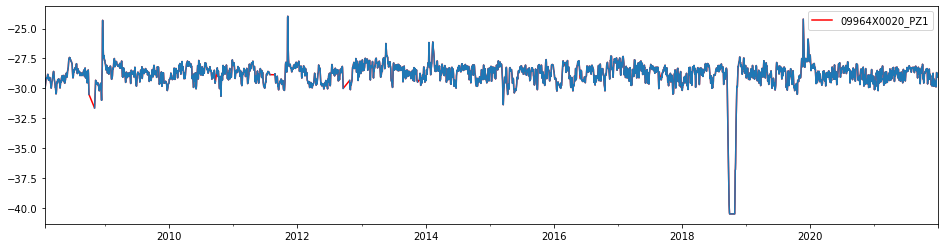

In [8]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
for piezo in piezos_communs:
    df = pd.read_csv(f"./data/combined_data/comb_{piezo}.csv", sep=";", index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df_interpol = df.copy().interpolate()
    df_interpol.piezo.plot(figsize=(16,4), color='r')
    df.piezo.plot( figsize=(16,4))
    plt.legend([f'{piezo}'])
    plt.show()

# 03646X0086_F1 - Chargement des données

**piezo** : "profodeur de la surface de nappe"  
**t2m** :   "2m_temperature"  
**cp** :    "convective_precipitation"  
**crr** :   "convective_rain_rate  
**csf** :   "convective_snowfall"   
**lsrr** :  "large_scale_rain_rate"  
**lsf** :   "large_scale_snowfall"  
**lssfr** : "large_scale_snowfall_rate_water_equivalent"  
**pev** :   "potential_evaporation"  
**sf** :    "snowfall"  
**tp** :    "total_precipitation"

## Chargement et affichage des données

In [9]:
piezo = "03646X0086_F1"
path = f"./data/combined_data/comb_{piezo}"

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
df = pd.read_csv(f"{path}.csv", sep=";", index_col=0, parse_dates=True, date_parser=custom_date_parser)
df.head()

piezo        t2m   cp           crr  csf          lsrr       lsf  \
2001-11-16 -27.47  272.87790  0.0  5.820766e-11  0.0  0.000000e+00  0.000000   
2001-11-17 -27.44  272.96494  0.0  5.820766e-11  0.0  0.000000e+00  0.000000   
2001-11-18 -27.41  272.31760  0.0  5.820766e-11  0.0  0.000000e+00  0.000000   
2001-11-19 -27.40  274.19595  0.0  5.820766e-11  0.0  1.753925e-05  0.000006   
2001-11-20 -27.41  274.90990  0.0  5.820766e-11  0.0  1.105946e-07  0.000000   

            lssfr       pev            sf            tp  
2001-11-16    0.0 -0.000003  5.820766e-11  2.328306e-10  
2001-11-17    0.0  0.000008  5.820766e-11  2.328306e-10  
2001-11-18    0.0  0.000014  5.820766e-11  2.328306e-10  
2001-11-19    0.0 -0.000003  6.122282e-06  3.613951e-05  
2001-11-20    0.0 -0.000002  5.820766e-11  5.397014e-07

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

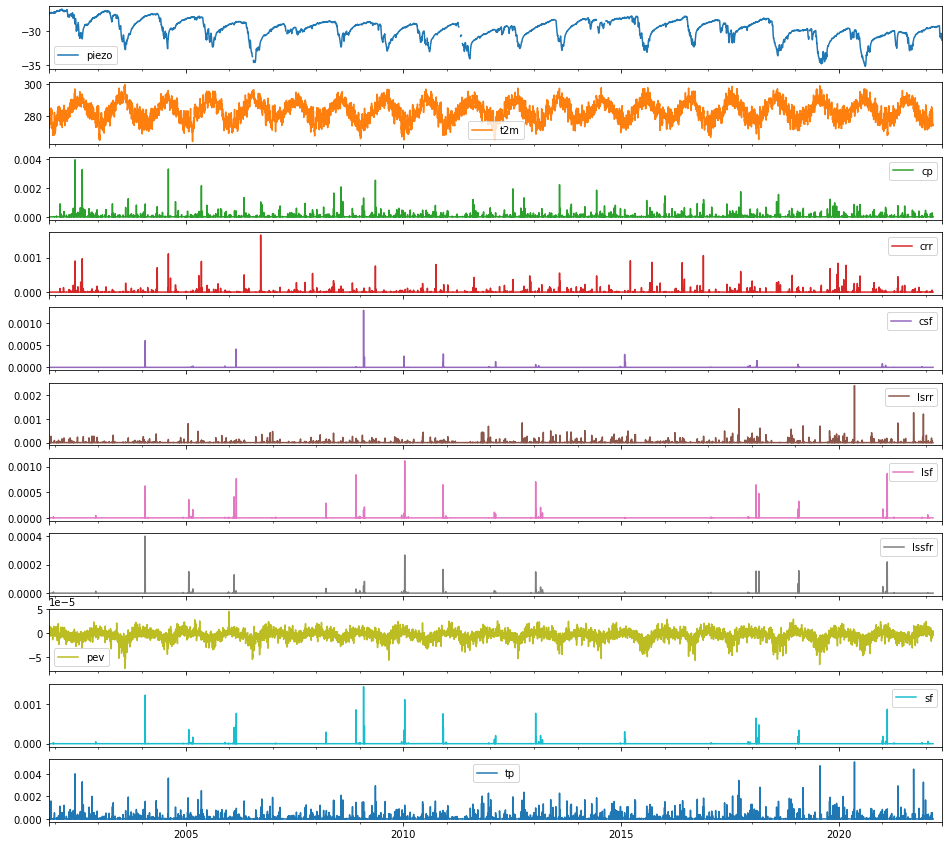

In [10]:
df.plot(subplots=True, figsize=(16,15))

## Valeurs manquantes

<AxesSubplot:>

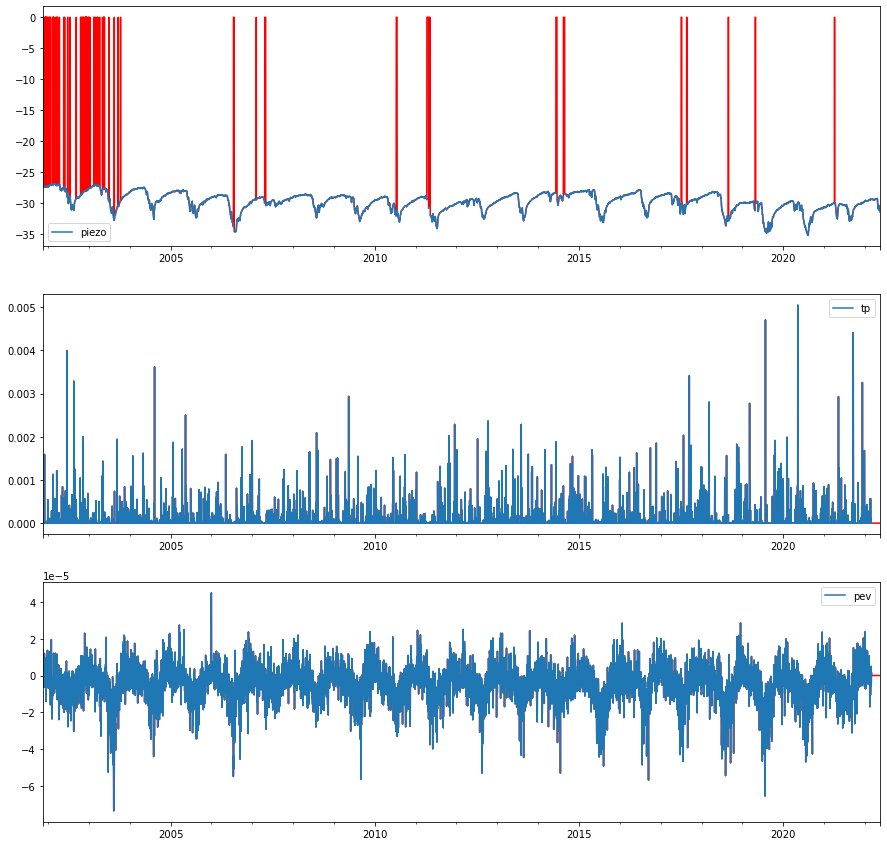

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df.piezo.plot(ax=ax[0],legend=True)

df.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df.tp.plot(ax=ax[1],legend=True)

df.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df.pev.plot(ax=ax[2],legend=True)

In [12]:
df_interpol = df.interpolate()

<AxesSubplot:>

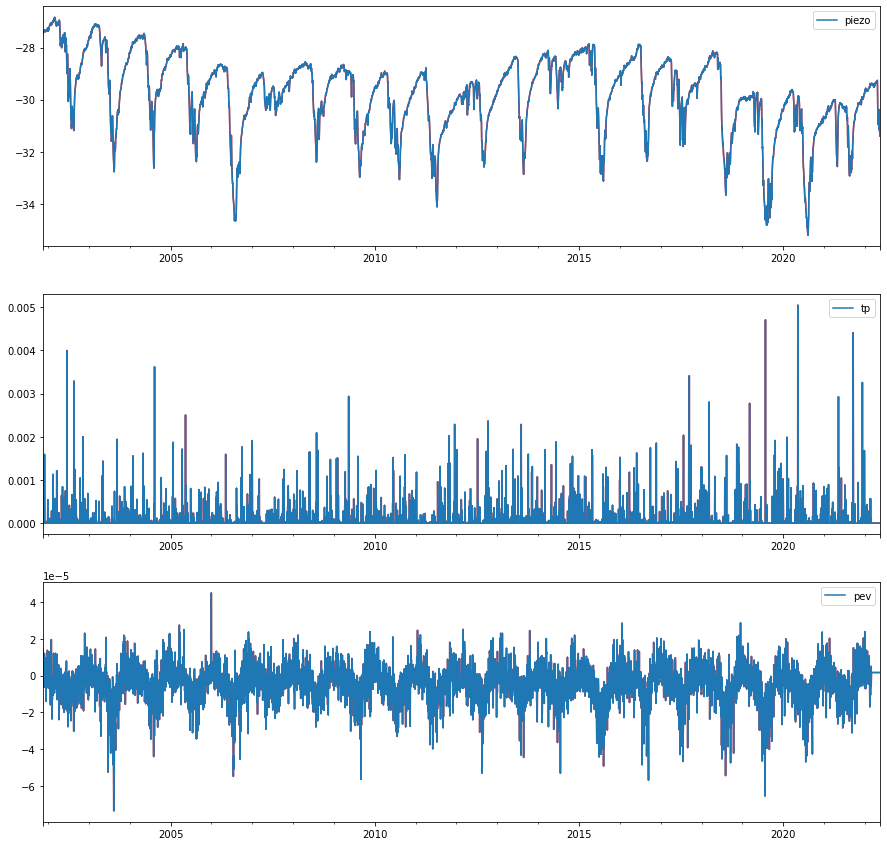

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df_interpol.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df_interpol.piezo.plot(ax=ax[0],legend=True)

df_interpol.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df_interpol.tp.plot(ax=ax[1],legend=True)

df_interpol.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df_interpol.pev.plot(ax=ax[2],legend=True)

## Lissage sur 7 jours

In [14]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window, center=False).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

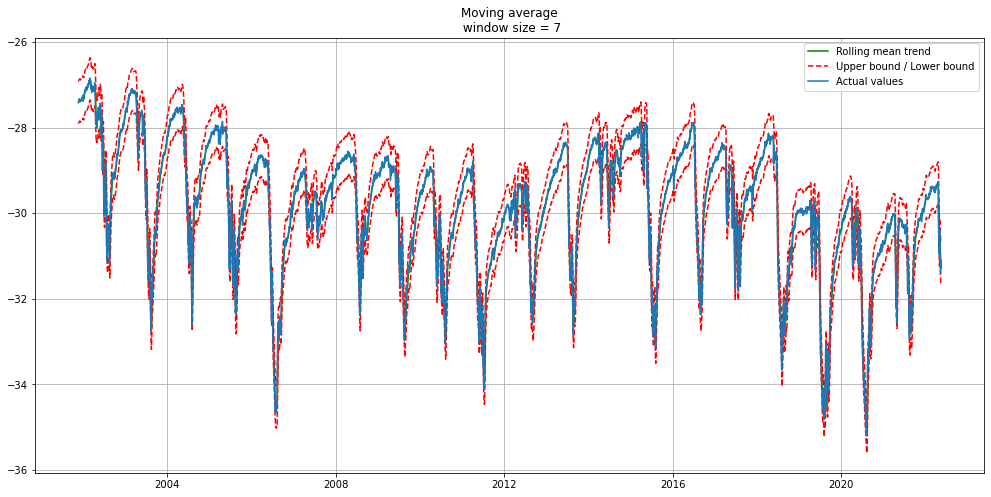

In [15]:
plot_moving_average(df_interpol.piezo, window=7, plot_intervals=True)

<AxesSubplot:>

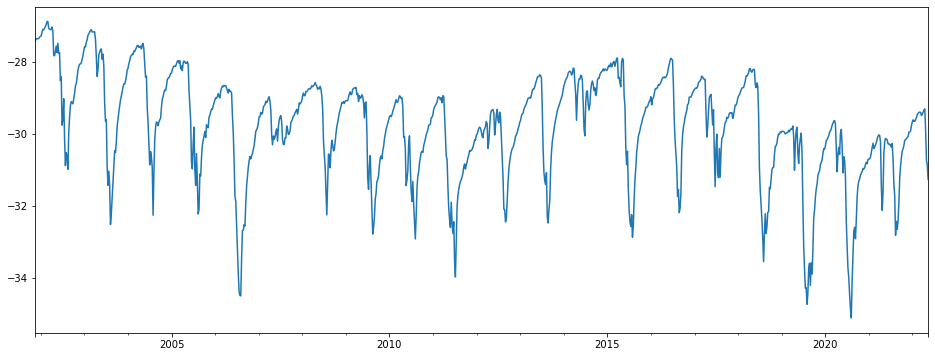

In [16]:
df_week = df_interpol.copy().resample('7D').mean()
df_week.piezo.plot(figsize=(16,6))

## Stationnarité

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()

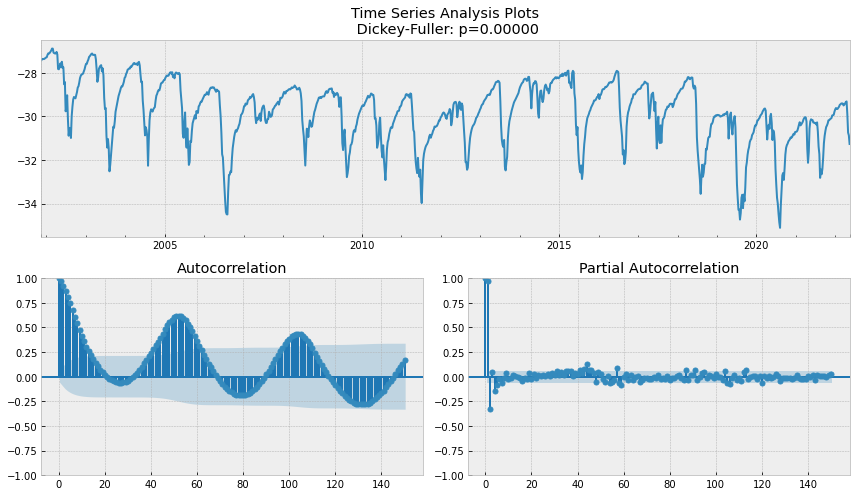

In [18]:
tsplot(df_week.piezo, lags=150)

## Saisonnalité

In [19]:
df.dropna(inplace=True)

In [20]:
core_columns =  ['piezo', 'tp', 'pev']

for column in core_columns:
    decomp = seasonal_decompose(df[column][1:], model='additive', extrapolate_trend='freq', period=52)
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

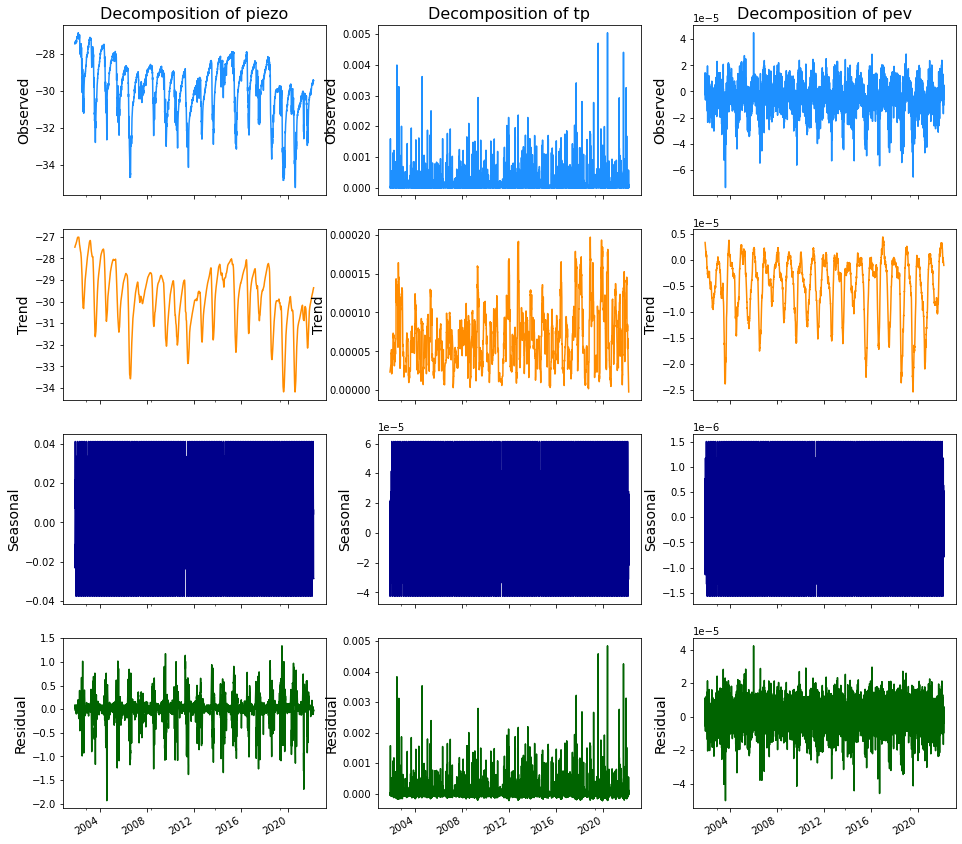

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(16,16))

for i, column in enumerate(core_columns):
    
    res = seasonal_decompose(df[column][1:], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='darkorange')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='darkblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='darkgreen')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

## Corrélation

<AxesSubplot:>

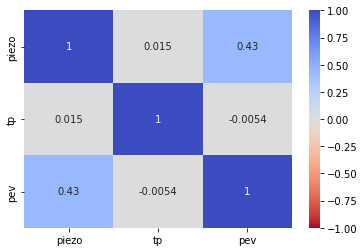

In [22]:
corrmat = df[core_columns].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')

# 03287X0018_S1 - Chargement des données

**piezo** : "profodeur de la surface de nappe"  
**t2m** :   "2m_temperature"  
**cp** :    "convective_precipitation"  
**crr** :   "convective_rain_rate  
**csf** :   "convective_snowfall"   
**lsrr** :  "large_scale_rain_rate"  
**lsf** :   "large_scale_snowfall"  
**lssfr** : "large_scale_snowfall_rate_water_equivalent"  
**pev** :   "potential_evaporation"  
**sf** :    "snowfall"  
**tp** :    "total_precipitation"

## Chargement et affichage des données

In [23]:
piezo = "03287X0018_S1"
path = f"./data/combined_data/comb_{piezo}"

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv(f"{path}.csv", sep=";", index_col=0, parse_dates=True, date_parser=custom_date_parser)
df.head()

piezo        t2m            cp           crr       csf  \
1995-01-01 -20.82  278.27640  1.135049e-07  5.820766e-11  0.000000   
1995-01-02 -20.88  274.53055  8.163881e-05  2.111122e-05  0.000002   
1995-01-03 -20.91  272.98990  1.164153e-10  5.820766e-11  0.000000   
1995-01-04 -20.88  272.49640  1.164153e-10  5.820766e-11  0.000000   
1995-01-05 -20.84  267.53467  1.164153e-10  5.820766e-11  0.000000   

                    lsrr           lsf         lssfr       pev            sf  \
1995-01-01  7.001217e-07 -5.820766e-11  0.000000e+00 -0.000005  0.000000e+00   
1995-01-02  4.790491e-07  1.216133e-05  6.945396e-06 -0.000003  1.399271e-05   
1995-01-03  0.000000e+00  7.213675e-07  1.773005e-07 -0.000002  7.152557e-07   
1995-01-04  0.000000e+00 -5.820766e-11  0.000000e+00  0.000002  0.000000e+00   
1995-01-05  0.000000e+00 -5.820766e-11  0.000000e+00  0.000001  0.000000e+00   

                      tp  
1995-01-01  4.680129e-06  
1995-01-02  1.161119e-04  
1995-01-03  6.686896e-07  
1995-01-04  0.000000e+00  
1995-01-05  0.000000e+00

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

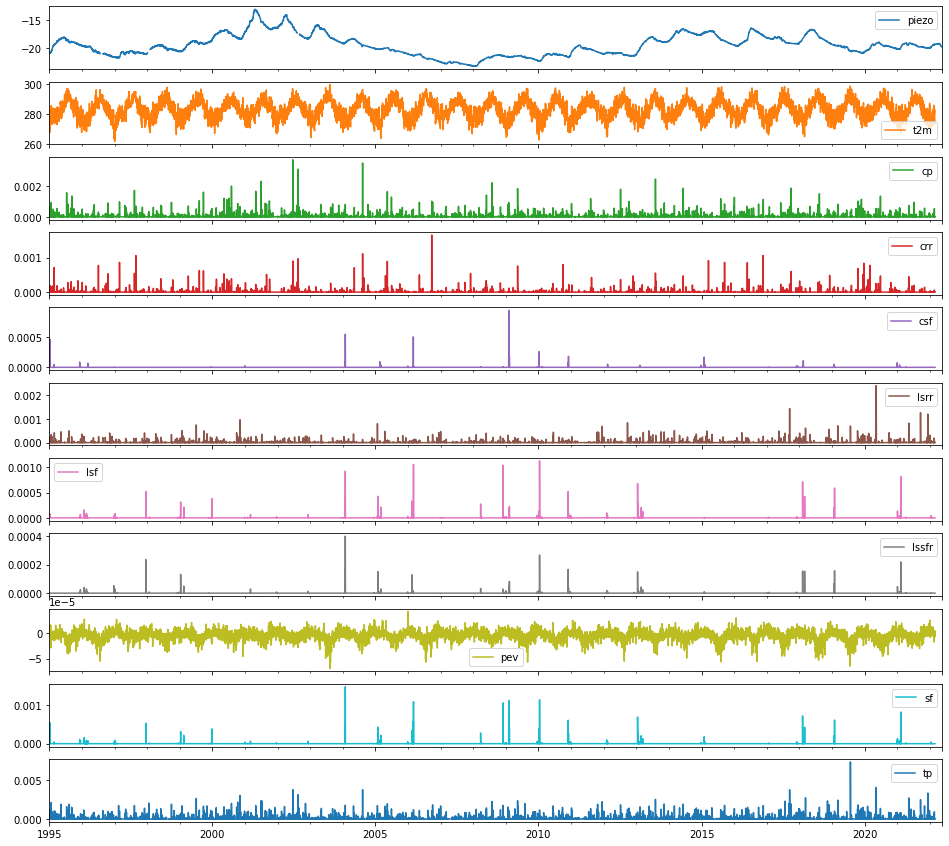

In [24]:
df.plot(subplots=True, figsize=(16,15))

## Valeurs manquantes

<AxesSubplot:>

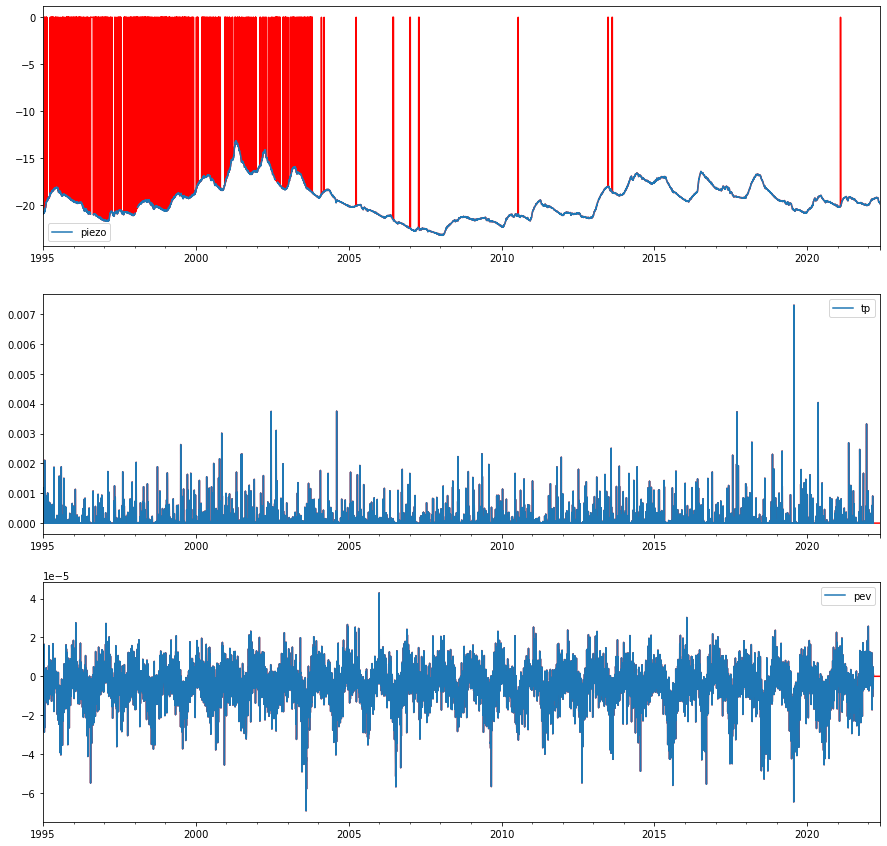

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df.piezo.plot(ax=ax[0],legend=True)

df.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df.tp.plot(ax=ax[1],legend=True)

df.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df.pev.plot(ax=ax[2],legend=True)

In [26]:
df_interpol = df.interpolate()

<AxesSubplot:>

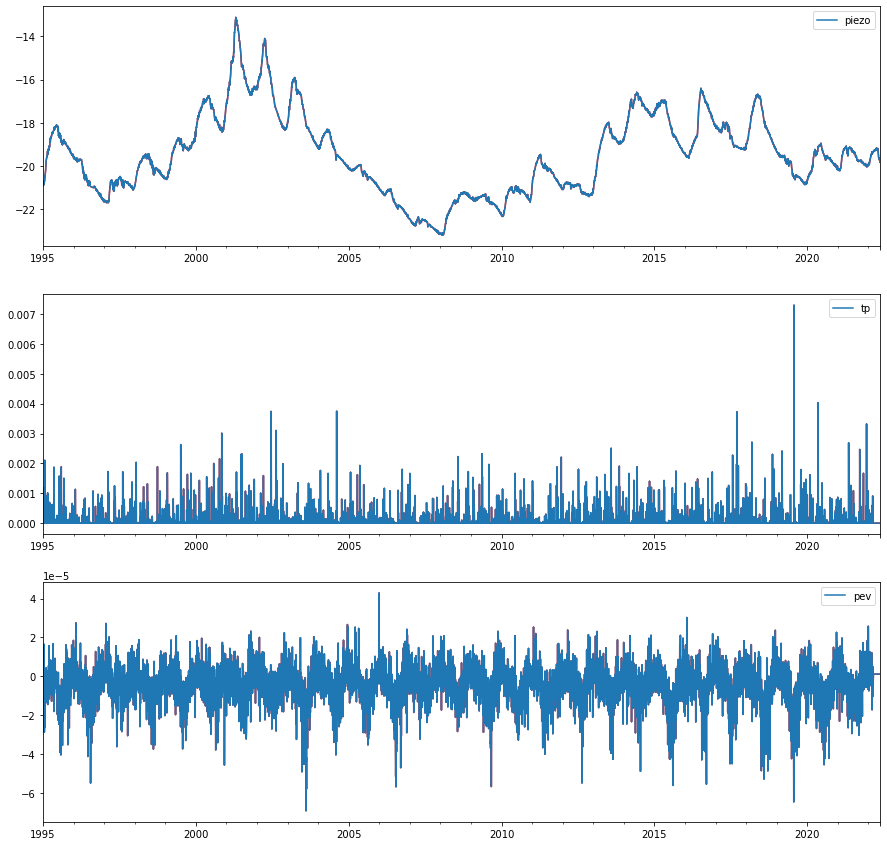

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df_interpol.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df_interpol.piezo.plot(ax=ax[0],legend=True)

df_interpol.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df_interpol.tp.plot(ax=ax[1],legend=True)

df_interpol.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df_interpol.pev.plot(ax=ax[2],legend=True)

## Lissage sur 7 jours

In [28]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window, center=False).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

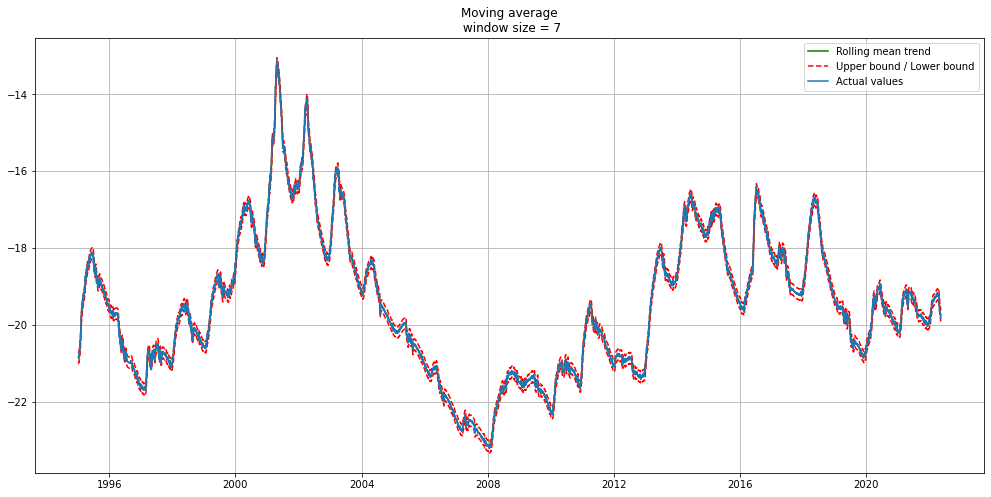

In [29]:
plot_moving_average(df_interpol.piezo, window=7, plot_intervals=True)

<AxesSubplot:>

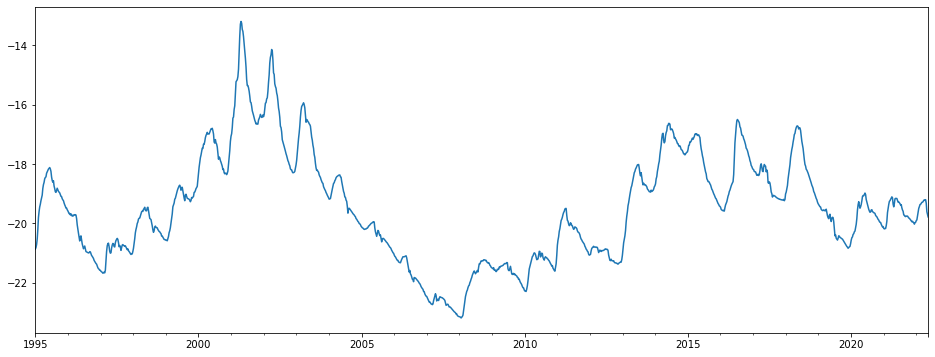

In [30]:
df_week = df_interpol.copy().resample('7D').mean()
df_week.piezo.plot(figsize=(16,6))

## Stationnarité

In [31]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()

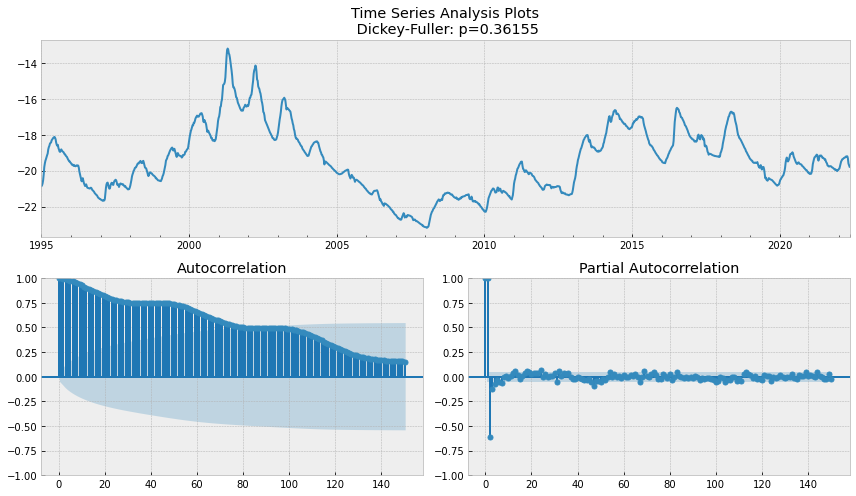

In [32]:
tsplot(df_week.piezo, lags=150)

## Saisonnalité

In [33]:
df.dropna(inplace=True)

In [34]:
core_columns =  ['piezo', 'tp', 'pev']

for column in core_columns:
    decomp = seasonal_decompose(df[column][1:], model='additive', extrapolate_trend='freq', period=52)
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

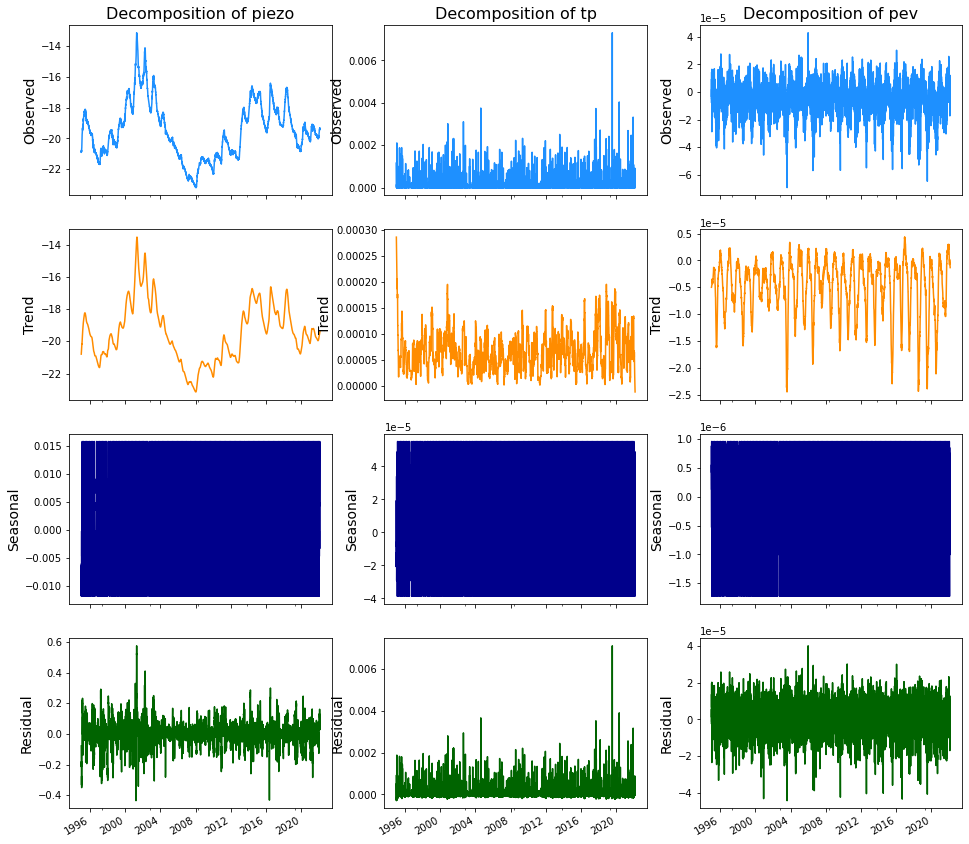

In [35]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(16,16))

for i, column in enumerate(core_columns):
    
    res = seasonal_decompose(df[column][1:], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='darkorange')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='darkblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='darkgreen')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

## Corrélation

<AxesSubplot:>

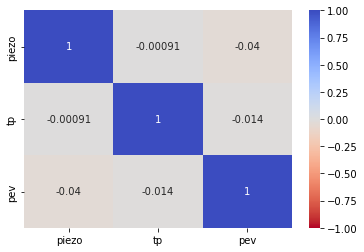

In [36]:
corrmat = df[core_columns].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')

# 03296X1032_PC1 - Chargement des données

**piezo** : "profodeur de la surface de nappe"  
**t2m** :   "2m_temperature"  
**cp** :    "convective_precipitation"  
**crr** :   "convective_rain_rate  
**csf** :   "convective_snowfall"   
**lsrr** :  "large_scale_rain_rate"  
**lsf** :   "large_scale_snowfall"  
**lssfr** : "large_scale_snowfall_rate_water_equivalent"  
**pev** :   "potential_evaporation"  
**sf** :    "snowfall"  
**tp** :    "total_precipitation"

## Chargement et affichage des données

In [37]:
piezo = "03296X1032_PC1"
path = f"./data/combined_data/comb_{piezo}"

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv(f"{path}.csv", sep=";", index_col=0, parse_dates=True, date_parser=custom_date_parser)
df.head()

piezo        t2m        cp       crr       csf      lsrr  \
1995-01-01 -14.61  278.23932  0.000006  0.000003  0.000000  0.000003   
1995-01-02 -14.68  274.34875  0.000099  0.000015  0.000017  0.000000   
1995-01-03 -14.74  273.18863  0.000000  0.000000  0.000000  0.000000   
1995-01-04 -14.85  272.46848  0.000000  0.000000  0.000000  0.000000   
1995-01-05 -14.75  267.44640  0.000000  0.000000  0.000000  0.000000   

                 lsf         lssfr           pev            sf        tp  
1995-01-01  0.000000  0.000000e+00 -4.423384e-06 -5.820766e-11  0.000018  
1995-01-02  0.000032  1.034307e-05 -3.273867e-06  4.821166e-05  0.000141  
1995-01-03  0.000002  5.967158e-07 -1.946065e-06  1.927430e-06  0.000002  
1995-01-04  0.000000  0.000000e+00  1.320803e-06 -5.820766e-11  0.000000  
1995-01-05  0.000000  0.000000e+00  8.555626e-07 -5.820766e-11  0.000000

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

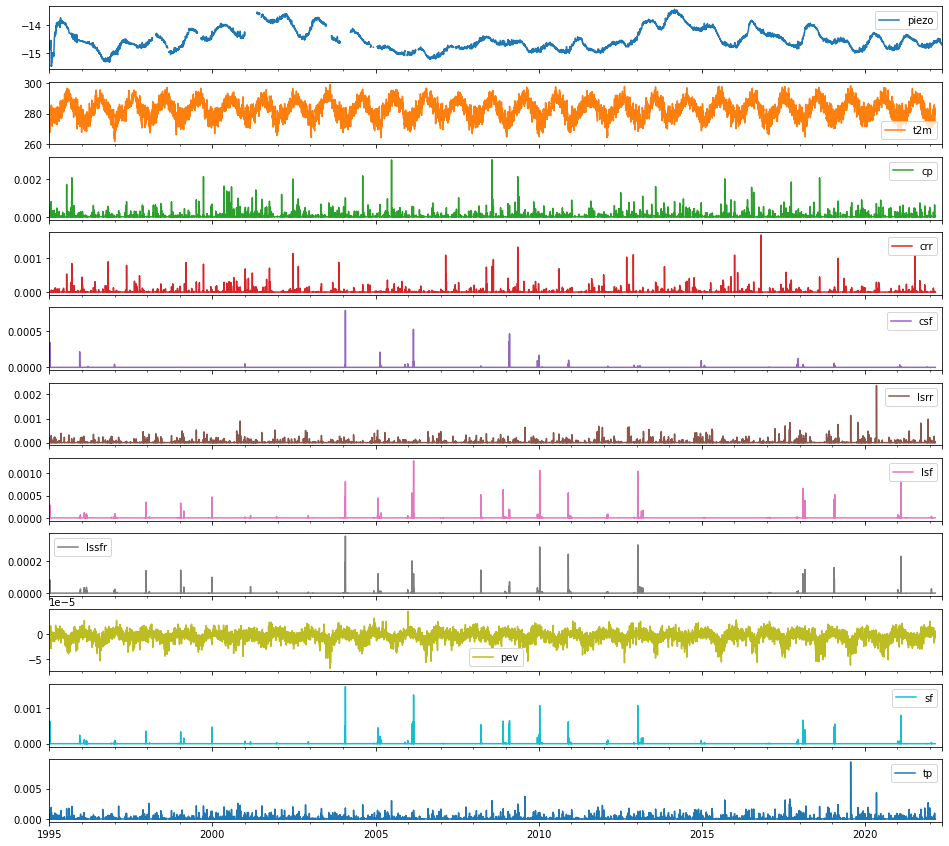

In [38]:
df.plot(subplots=True, figsize=(16,15))

## Valeurs manquantes

<AxesSubplot:>

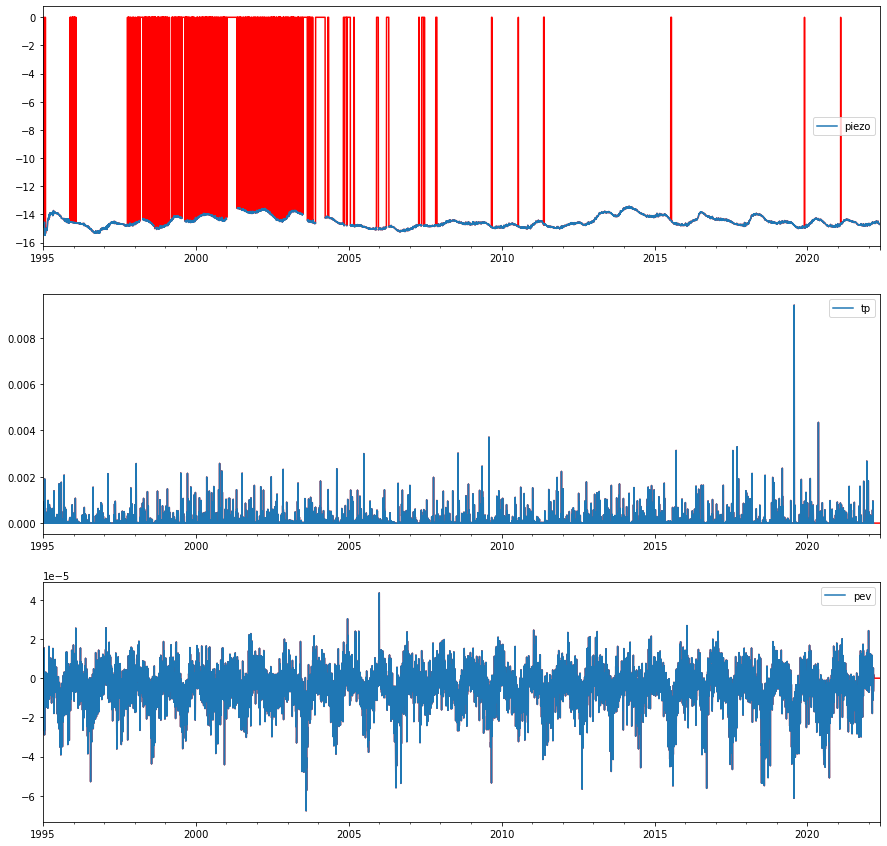

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df.piezo.plot(ax=ax[0],legend=True)

df.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df.tp.plot(ax=ax[1],legend=True)

df.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df.pev.plot(ax=ax[2],legend=True)

In [40]:
df_interpol = df.interpolate()

<AxesSubplot:>

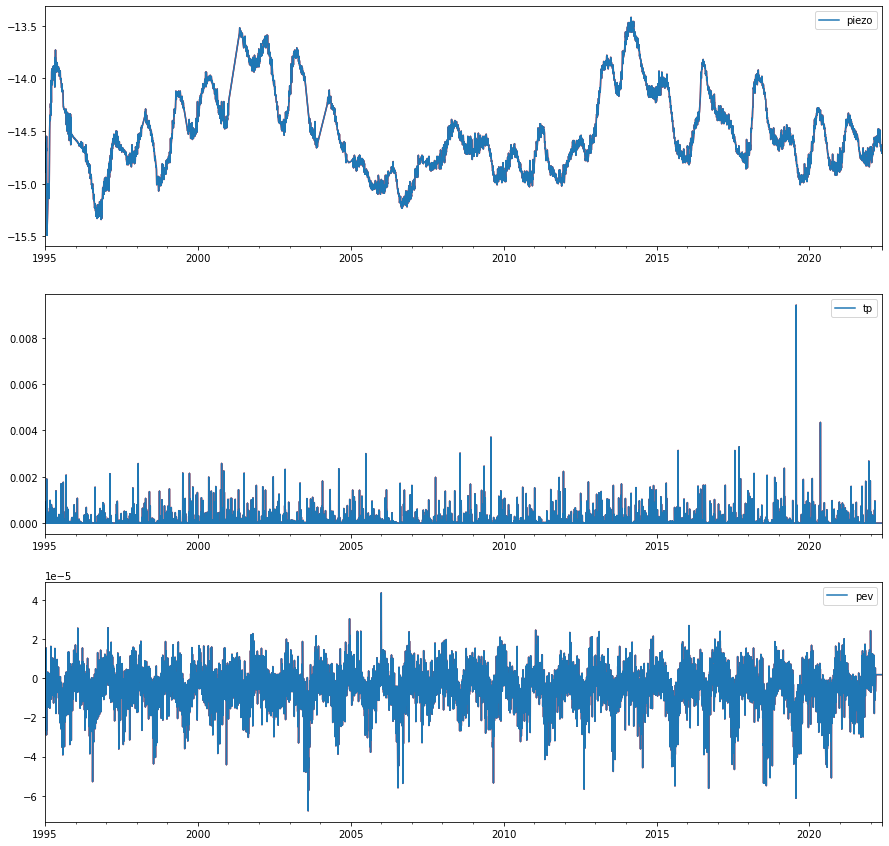

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df_interpol.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df_interpol.piezo.plot(ax=ax[0],legend=True)

df_interpol.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df_interpol.tp.plot(ax=ax[1],legend=True)

df_interpol.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df_interpol.pev.plot(ax=ax[2],legend=True)

## Lissage sur 7 jours

In [42]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window, center=False).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

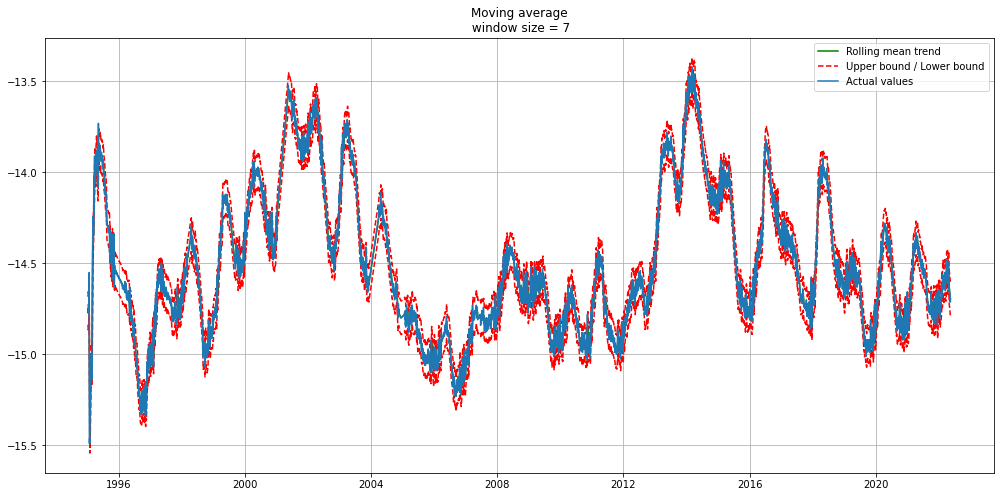

In [43]:
plot_moving_average(df_interpol.piezo, window=7, plot_intervals=True)

<AxesSubplot:>

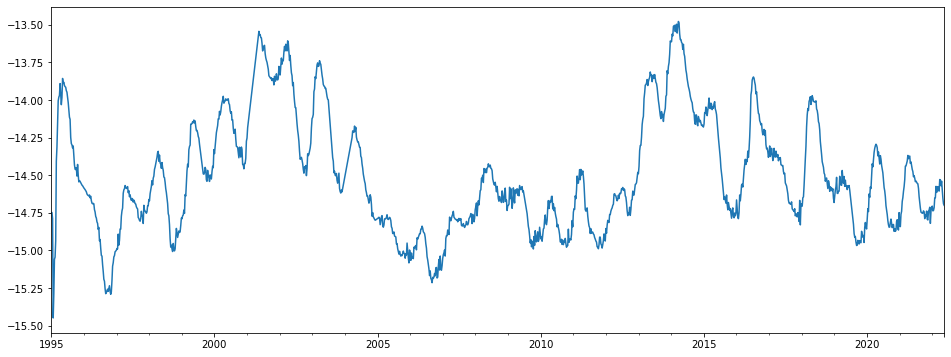

In [44]:
df_week = df_interpol.copy().resample('7D').mean()
df_week.piezo.plot(figsize=(16,6))

## Stationnarité

In [45]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()

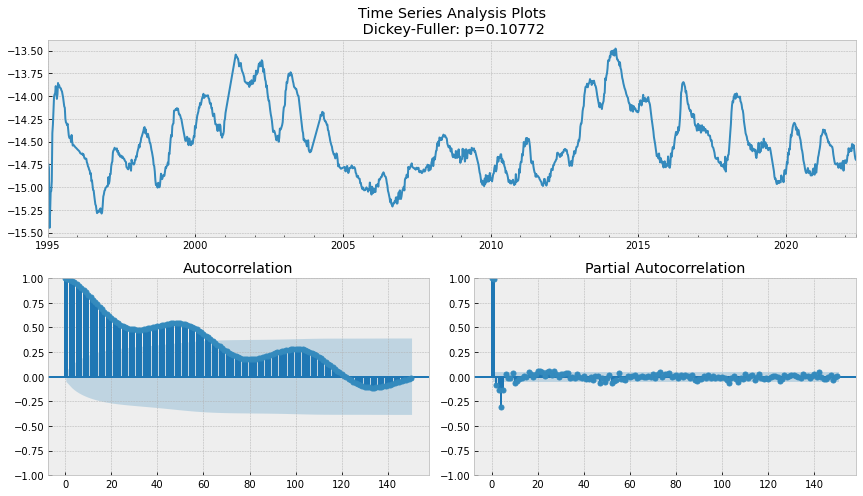

In [46]:
tsplot(df_week.piezo, lags=150)

## Saisonnalité

In [47]:
df.dropna(inplace=True)

In [48]:
core_columns =  ['piezo', 'tp', 'pev']

for column in core_columns:
    decomp = seasonal_decompose(df[column][1:], model='additive', extrapolate_trend='freq', period=52)
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

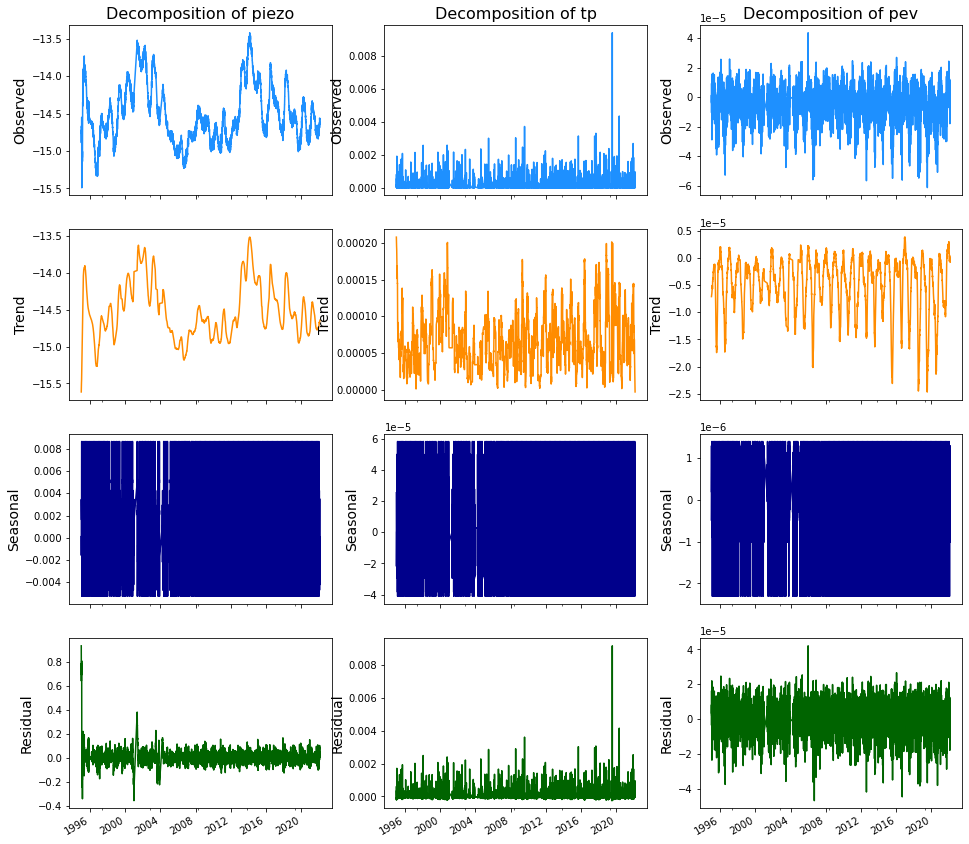

In [49]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(16,16))

for i, column in enumerate(core_columns):
    
    res = seasonal_decompose(df[column][1:], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='darkorange')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='darkblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='darkgreen')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

## Corrélation

<AxesSubplot:>

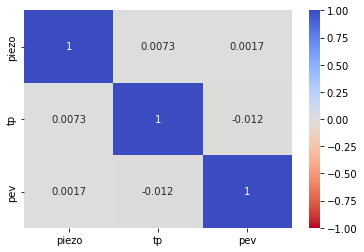

In [50]:
corrmat = df[core_columns].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')

# 03627X0052_P1 - Chargement des données

**piezo** : "profodeur de la surface de nappe"  
**t2m** :   "2m_temperature"  
**cp** :    "convective_precipitation"  
**crr** :   "convective_rain_rate  
**csf** :   "convective_snowfall"   
**lsrr** :  "large_scale_rain_rate"  
**lsf** :   "large_scale_snowfall"  
**lssfr** : "large_scale_snowfall_rate_water_equivalent"  
**pev** :   "potential_evaporation"  
**sf** :    "snowfall"  
**tp** :    "total_precipitation"

## Chargement et affichage des données

In [51]:
piezo = "03627X0052_P1"
path = f"./data/combined_data/comb_{piezo}"

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv(f"{path}.csv", sep=";", index_col=0, parse_dates=True, date_parser=custom_date_parser)
df.head(5)

piezo        t2m        cp           crr  csf          lsrr  \
1995-01-01    NaN  278.27493  0.000000  5.820766e-11  0.0  2.416782e-07   
1995-01-02    NaN  275.22766  0.000043  5.820766e-11  0.0  2.854969e-06   
1995-01-03    NaN  272.20184  0.000000  5.820766e-11  0.0  0.000000e+00   
1995-01-04 -11.21  272.54690  0.000000  5.820766e-11  0.0  1.208391e-07   
1995-01-05    NaN  268.09610  0.000000  5.820766e-11  0.0  0.000000e+00   

                 lsf         lssfr       pev        sf            tp  
1995-01-01  0.000000  1.455191e-11 -0.000007  0.000000  1.773471e-06  
1995-01-02  0.000002  1.455191e-11 -0.000003  0.000002  7.637090e-05  
1995-01-03  0.000000  1.455191e-11 -0.000002  0.000000  0.000000e+00  
1995-01-04  0.000000  1.455191e-11  0.000002  0.000000  4.988397e-07  
1995-01-05  0.000000  1.455191e-11  0.000002  0.000000  0.000000e+00

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

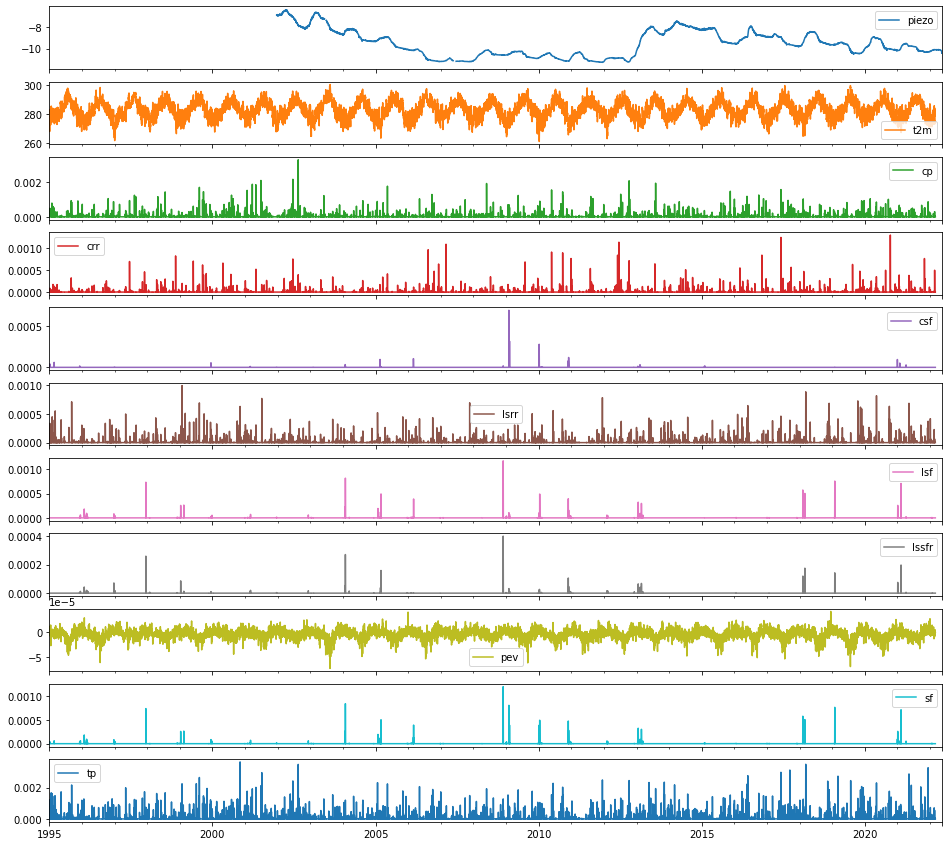

In [52]:
df.plot(subplots=True, figsize=(16,15))

## Valeurs manquantes

<AxesSubplot:>

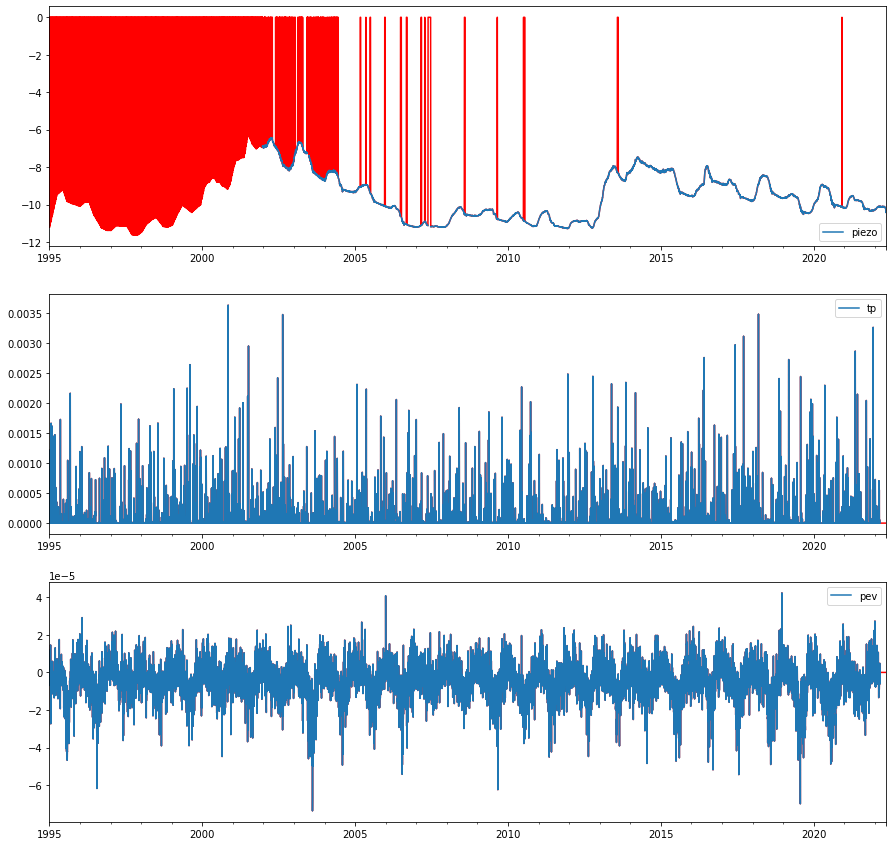

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df.piezo.plot(ax=ax[0],legend=True)

df.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df.tp.plot(ax=ax[1],legend=True)

df.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df.pev.plot(ax=ax[2],legend=True)

In [54]:
df_interpol = df.interpolate()

<AxesSubplot:>

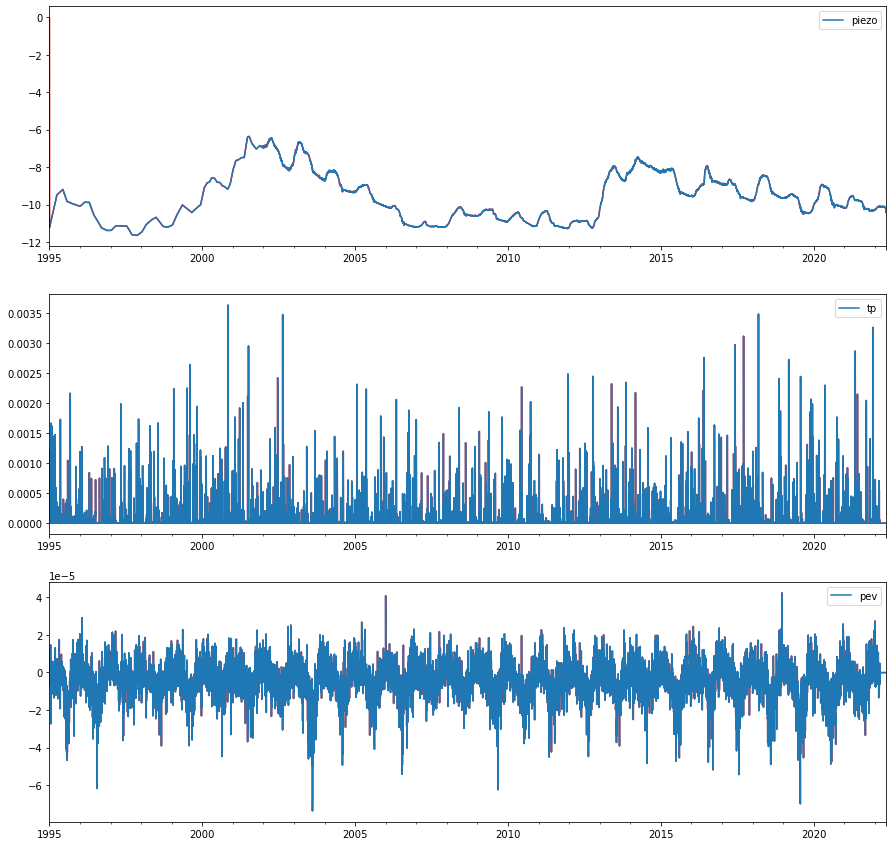

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

df_interpol.piezo.replace(np.nan,0).plot(ax=ax[0], color='red')
df_interpol.piezo.plot(ax=ax[0],legend=True)

df_interpol.tp.replace(np.nan,0).plot(ax=ax[1], color='red')
df_interpol.tp.plot(ax=ax[1],legend=True)

df_interpol.pev.replace(np.nan,0).plot(ax=ax[2], color='red')
df_interpol.pev.plot(ax=ax[2],legend=True)

## Lissage sur 7 jours

In [56]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window, center=False).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

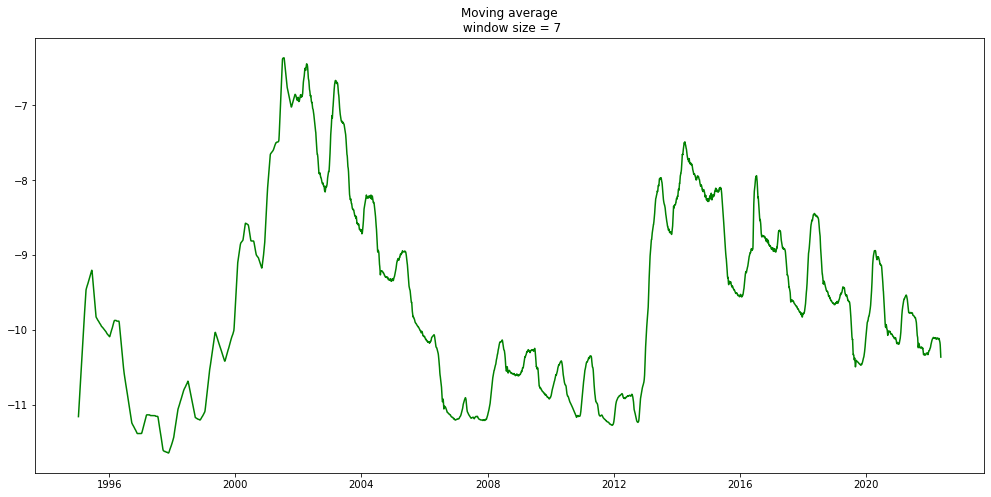

In [57]:
plot_moving_average(df_interpol.piezo, window=7, plot_intervals=True)

In [ ]:
df_week = df_interpol.copy().resample('7D').mean()
df_week.piezo.plot(figsize=(16,6))

## Stationnarité

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()

In [ ]:
tsplot(df_week.piezo, lags=150)

## Saisonnalité

In [ ]:
df.dropna(inplace=True)

In [ ]:
core_columns =  ['piezo', 'tp', 'pev']

for column in core_columns:
    decomp = seasonal_decompose(df[column][1:], model='additive', extrapolate_trend='freq', period=52)
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(16,16))

for i, column in enumerate(core_columns):
    
    res = seasonal_decompose(df[column][1:], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='darkorange')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='darkblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='darkgreen')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

## Corrélation

In [ ]:
corrmat = df[core_columns].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')